In [1]:
import pandas as pd
import gzip
#import pandas_profiling as pdp
from IPython.display import display
import dask.dataframe as dd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import matplotlib as mpl
import matplotlib.patches as mpatches

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import os
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import AR, ARMA

sns.set_style('whitegrid')
%matplotlib inline



%matplotlib inline
sns.set()
plt.rcParams['font.family'] = 'HGMaruGothicMPRO'
print(mpl.rcParams['font.family'])

C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


['HGMaruGothicMPRO']


In [2]:
# グラフを横長にする
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 6
sns.set()
# オブジェクトの保存
import pickle
# pystanの読み込み
import pystan

# データ読み込みからデータ成型まで

In [3]:
col_names = [ '日付開始','価格','最高価格','最低価格','終値','ボリューム','時価総額']
df_bitcoin = pd.read_csv('bitcoin2.csv',encoding="utf-8", names=col_names,skipinitialspace=True)
df_bitcoin.isnull().sum()
df_bitcoin=df_bitcoin.drop(0)



### 日付の表示形式を変更

In [4]:
df_bitcoin['日付開始'] = df_bitcoin['日付開始'].str.replace('年', '-')
df_bitcoin['日付開始'] = df_bitcoin['日付開始'].str.replace('月', '-')
df_bitcoin['日付開始'] = df_bitcoin['日付開始'].str.replace('日', '')
df_bitcoin['価格'] = df_bitcoin['価格'].str.replace(',', '')
df_bitcoin['最高価格'] = df_bitcoin['最高価格'].str.replace(',', '')
df_bitcoin['最低価格'] = df_bitcoin['最低価格'].str.replace(',', '')
df_bitcoin['終値'] = df_bitcoin['終値'].str.replace(',', '')
df_bitcoin['ボリューム'] = df_bitcoin['ボリューム'].str.replace(',', '')
df_bitcoin['時価総額'] = df_bitcoin['時価総額'].str.replace(',', '')

In [5]:
df_bitcoin['日付開始']=pd.to_datetime(df_bitcoin['日付開始'],format='%Y-%m-%d')

In [6]:
df_bitcoin.dtypes
df_bitcoin['価格']=df_bitcoin['価格'].astype('double')
df_bitcoin['最高価格']=df_bitcoin['最高価格'].astype('double')
df_bitcoin['最低価格']=df_bitcoin['最低価格'].astype('double')
df_bitcoin['終値']=df_bitcoin['終値'].astype('double')
#df_bitcoin['ボリューム']=df_bitcoin['ボリューム'].astype('double')
df_bitcoin['時価総額']=df_bitcoin['時価総額'].astype('double')

In [7]:
df_bitcoin=df_bitcoin.sort_values(by='日付開始',ascending=False)

In [8]:
df_bitcoin=df_bitcoin.drop(labels='ボリューム',axis=1)

# 基礎集計

## 時系列ごとに見てみる

In [9]:
bitgroup=df_bitcoin.groupby(pd.Grouper(key='日付開始',freq='1d')).sum()

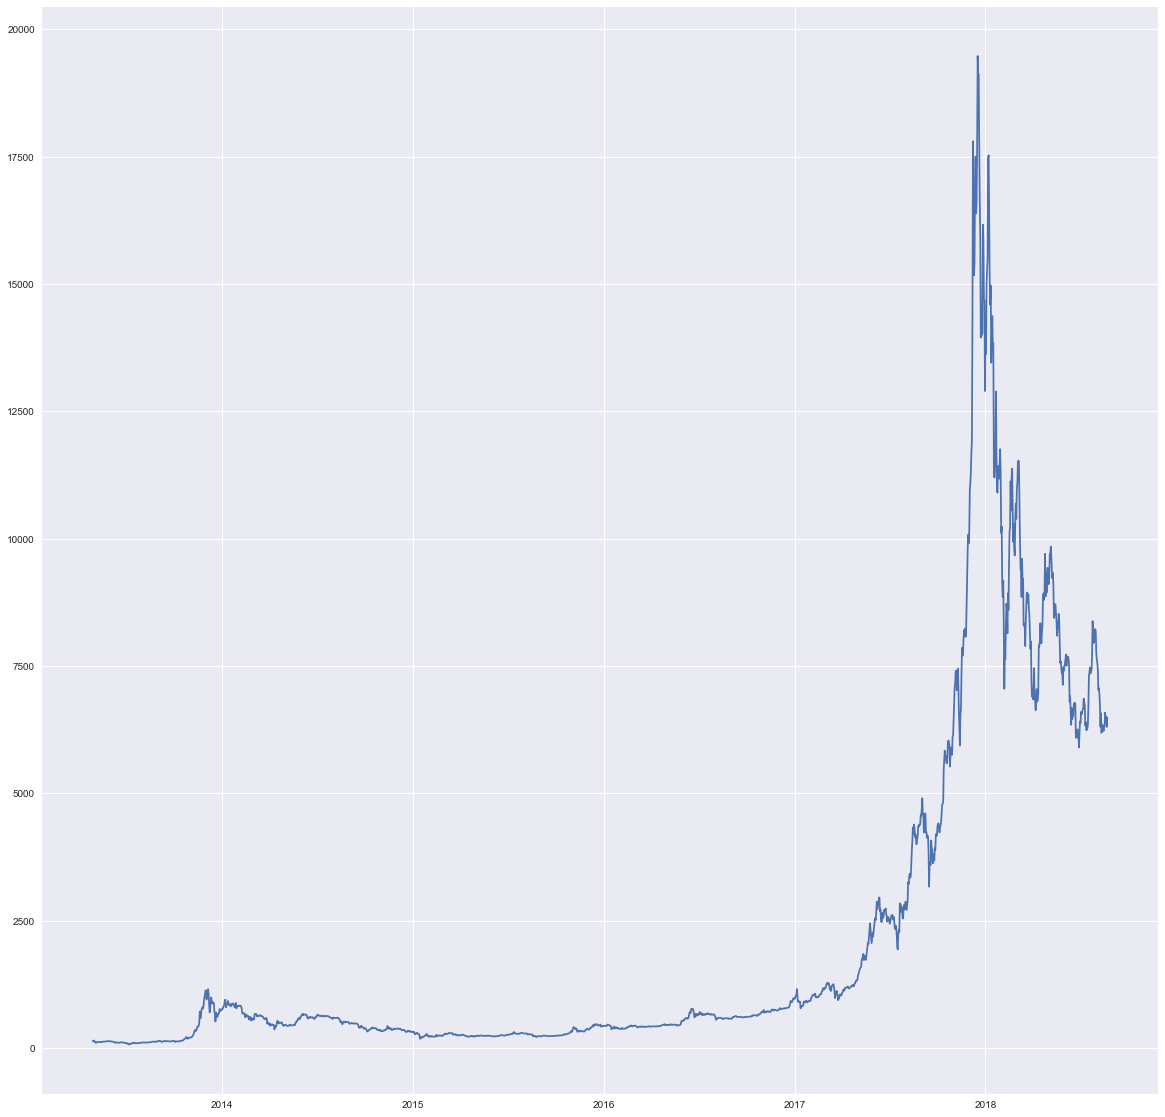

In [10]:
plt.figure(figsize=(20, 20))
plt.plot(df_bitcoin['日付開始'],df_bitcoin['価格'])

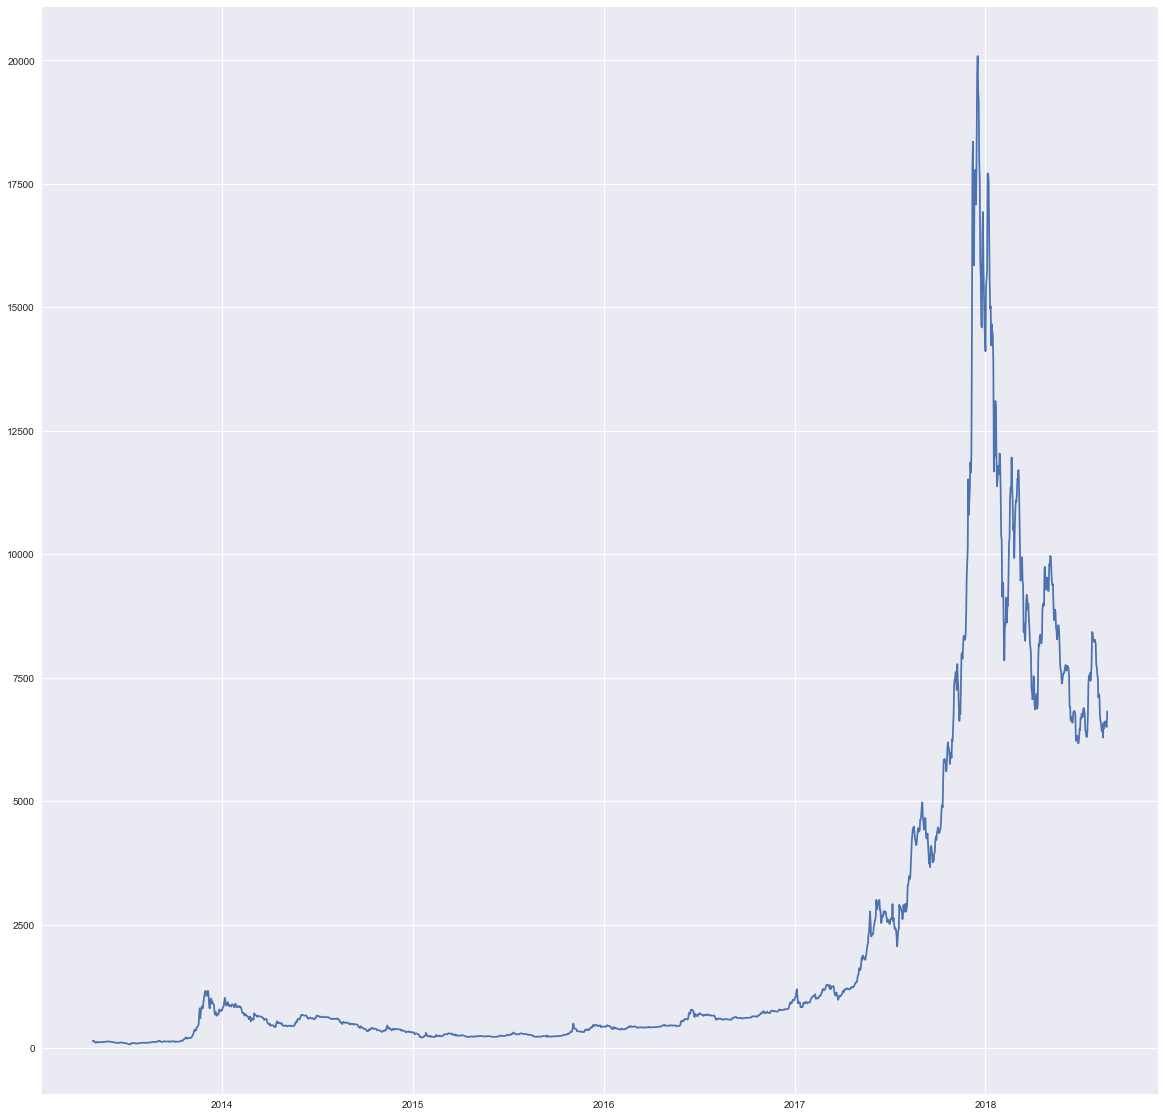

In [11]:
plt.figure(figsize=(20, 20))
plt.plot(df_bitcoin['日付開始'],df_bitcoin['最高価格'])

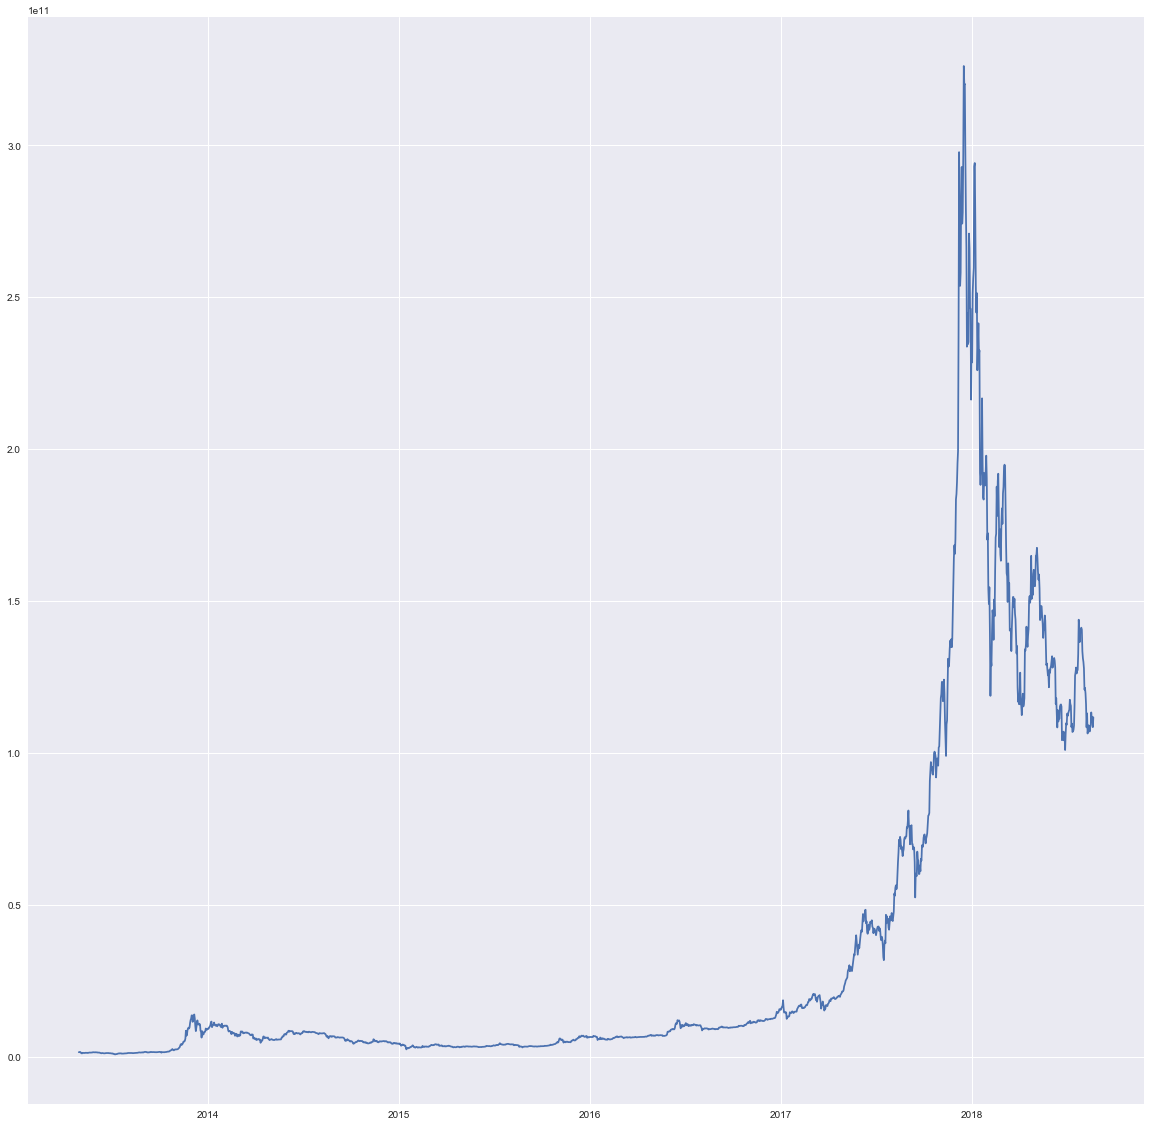

In [12]:
plt.figure(figsize=(20, 20))
plt.plot(df_bitcoin['日付開始'],df_bitcoin['時価総額'])

In [13]:
bitcoin_1m_mean=df_bitcoin.groupby(pd.Grouper(key='日付開始',freq='1m')).mean()
bitcoin_1m_mean=bitcoin_1m_mean.reset_index()

In [14]:
bitcoin_1y_mean=df_bitcoin.groupby(pd.Grouper(key='日付開始',freq='1y')).mean()
bitcoin_1y_mean=bitcoin_1y_mean.reset_index()
bitcoin_1y_mean

,日付開始,価格,最高価格,最低価格,終値,時価総額
0,2013-12-31,255.147944,269.322379,239.651935,257.474395,3.031221e+09
1,2014-12-31,528.404740,540.312000,514.366740,527.236548,6.795851e+09
2,2015-12-31,272.149041,278.151863,266.807918,272.453397,3.916406e+09
3,2016-12-31,567.141503,574.302295,560.453415,568.492213,8.906763e+09
4,2017-12-31,3970.644849,4144.687534,3811.707808,4006.033616,6.586193e+10
5,2018-12-31,8689.293632,8933.006923,8358.743419,8655.518632,1.474954e+11


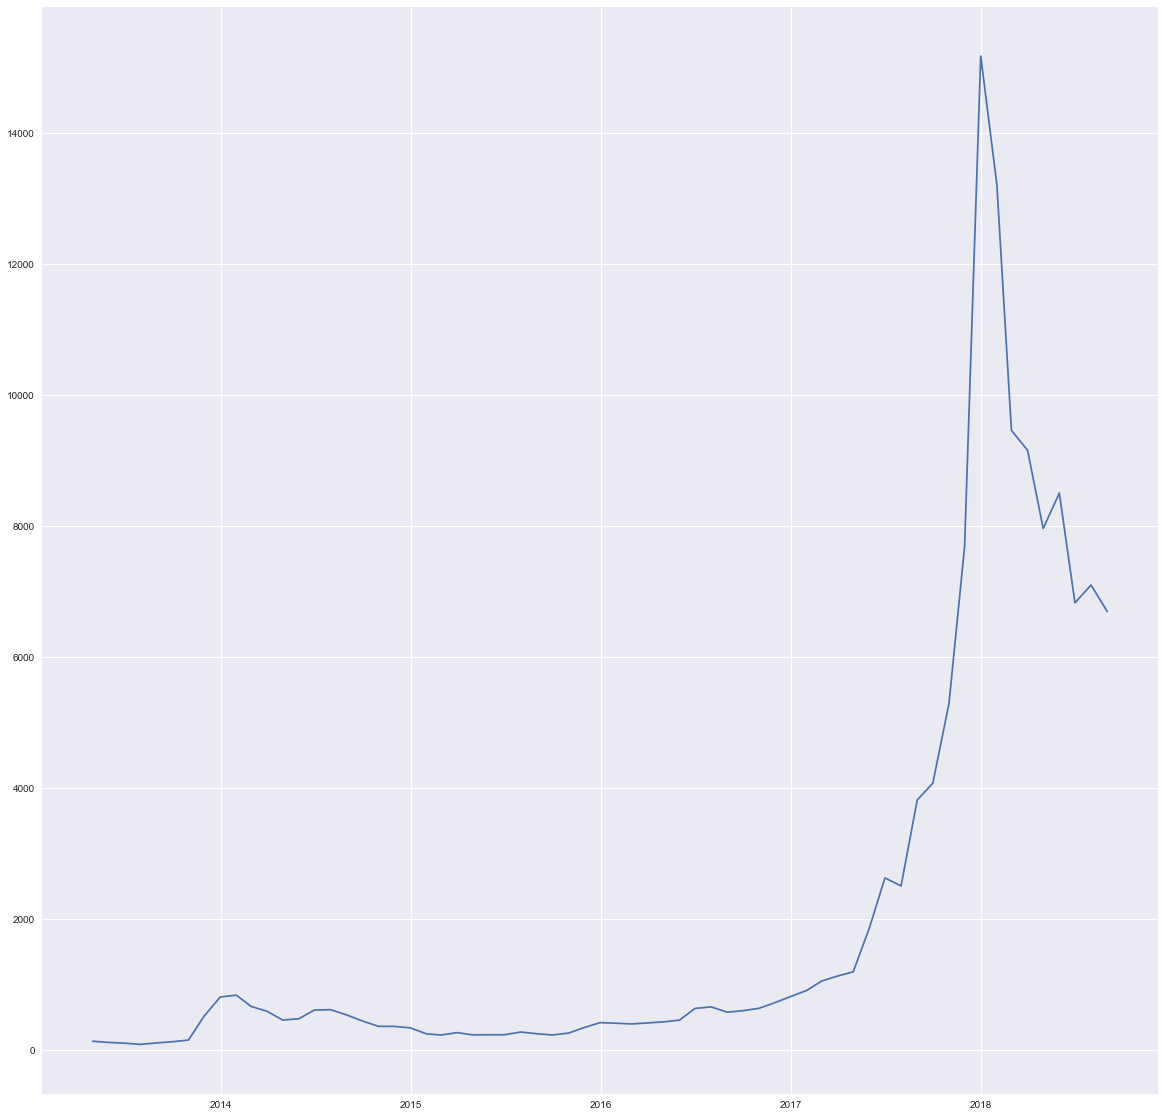

In [15]:
plt.figure(figsize=(20, 20))
plt.plot(bitcoin_1m_mean['日付開始'],bitcoin_1m_mean['価格'])

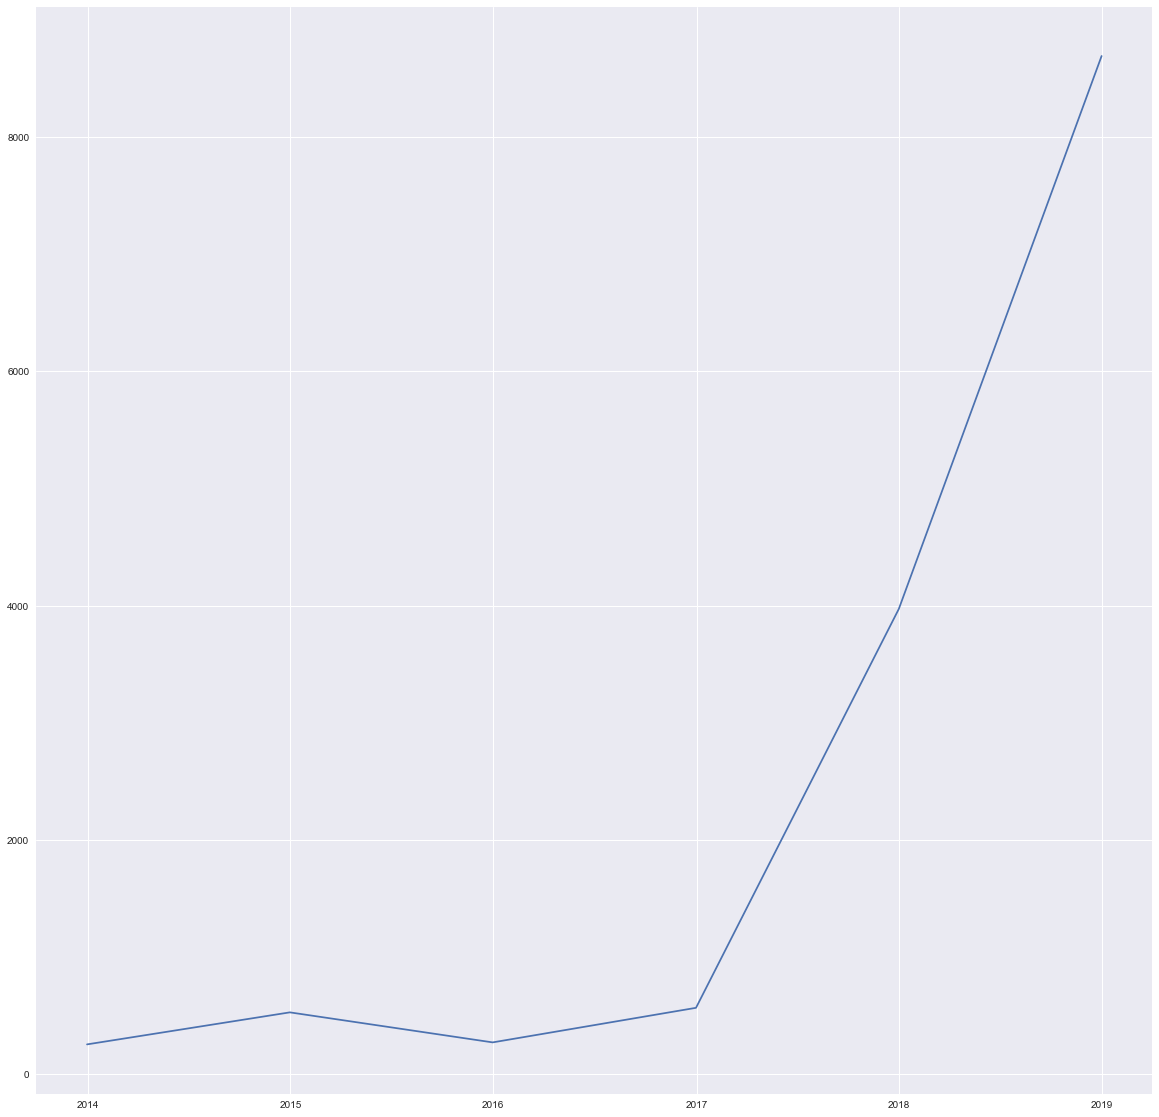

In [16]:
plt.figure(figsize=(20, 20))
plt.plot(bitcoin_1y_mean['日付開始'],bitcoin_1y_mean['価格'])

# 新カラム作成

In [17]:
df_bitcoin['kouteisa']=df_bitcoin['最高価格']-df_bitcoin['最低価格']

In [18]:
df_bitcoin['difference_1day'] = df_bitcoin['価格'].diff(periods=1)
df_bitcoin['difference_3day'] = df_bitcoin['価格'].diff(periods=3)
df_bitcoin['difference_7day'] = df_bitcoin['価格'].diff(periods=7)
df_bitcoin['difference_30day'] = df_bitcoin['価格'].diff(periods=30)
df_bitcoin['difference_60day'] = df_bitcoin['価格'].diff(periods=60)


In [19]:
df_bitcoin['pct_1d'] = df_bitcoin['価格'].pct_change(periods=1)
df_bitcoin['pct_3d'] = df_bitcoin['価格'].pct_change(periods=3)
df_bitcoin['pct_7d'] = df_bitcoin['価格'].pct_change(periods=7)
df_bitcoin['pct_30d'] = df_bitcoin['価格'].pct_change(periods=30)
df_bitcoin['pct_60d'] = df_bitcoin['価格'].pct_change(periods=60)

In [20]:
df_bitcoin['rolling_mean_1d']=pd.rolling_mean(df_bitcoin['価格'],window=1)
df_bitcoin['rolling_mean_3d']=pd.rolling_mean(df_bitcoin['価格'],window=3)
df_bitcoin['rolling_mean_7d']=pd.rolling_mean(df_bitcoin['価格'],window=7)
df_bitcoin['rolling_mean_30d']=pd.rolling_mean(df_bitcoin['価格'],window=30)
df_bitcoin['rolling_mean_60d']=pd.rolling_mean(df_bitcoin['価格'],window=60)

C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=1,center=False).mean()
  """Entry point for launching an IPython kernel.
C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
  
C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a f

# 新カラムを基礎集計

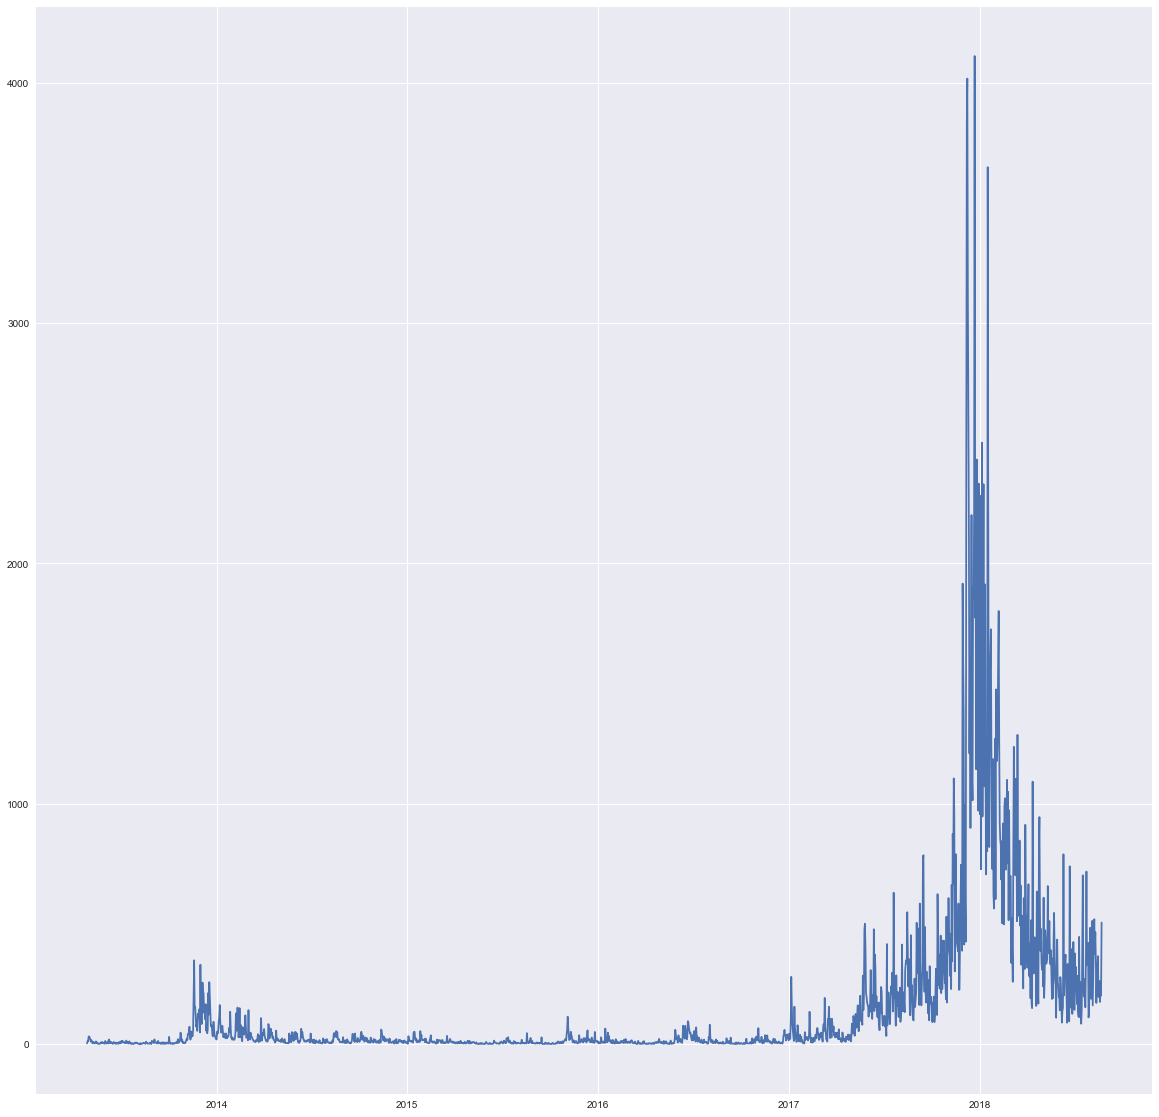

In [21]:
plt.figure(figsize=(20, 20))
plt.plot(df_bitcoin['日付開始'],df_bitcoin['kouteisa'])

## 差分集計

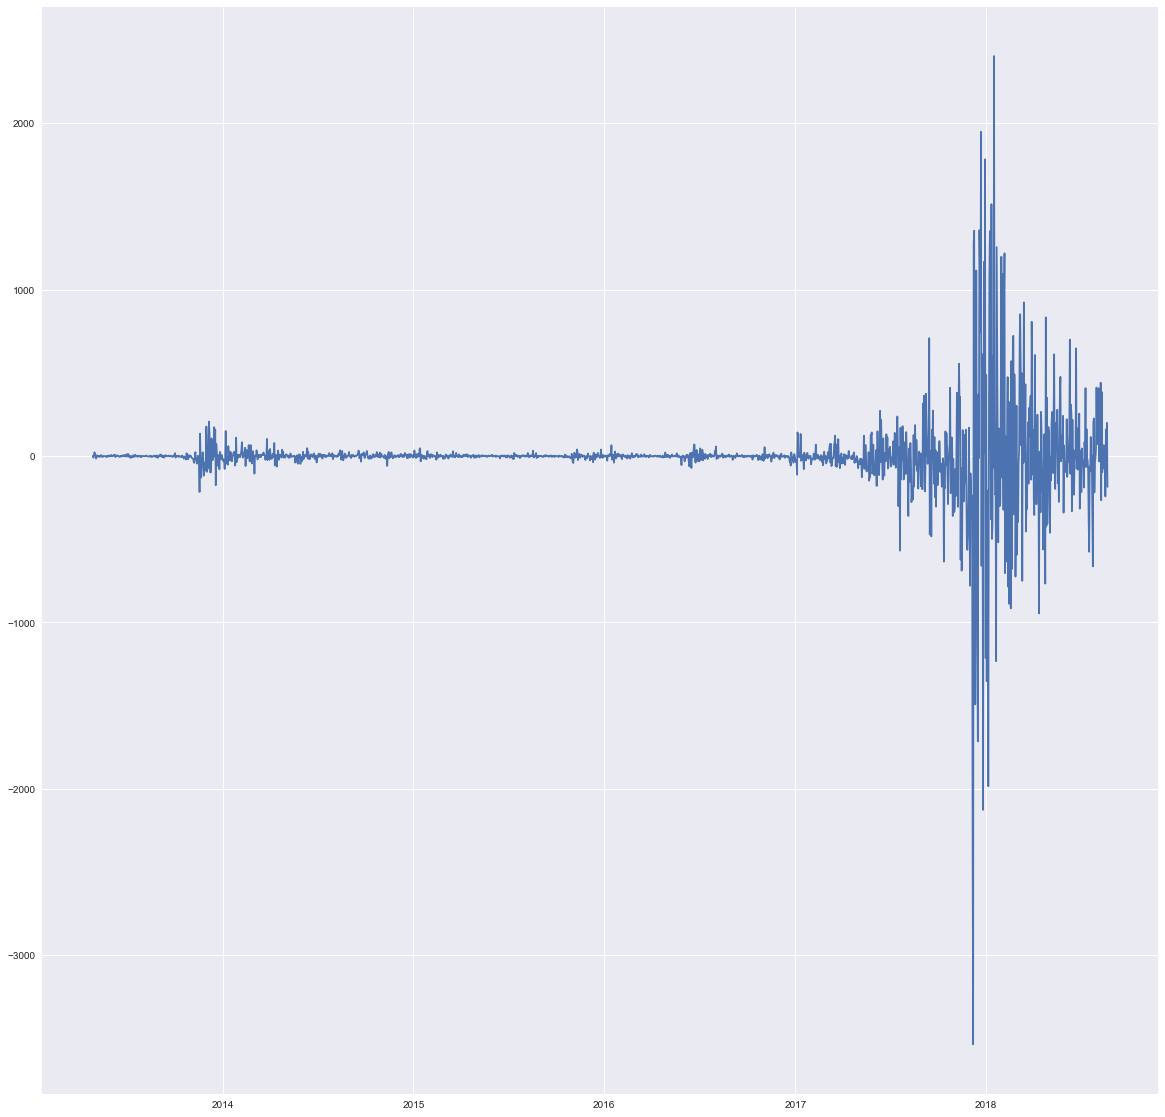

In [22]:
plt.figure(figsize=(20, 20))
plt.plot(df_bitcoin['日付開始'],df_bitcoin['difference_1day'])

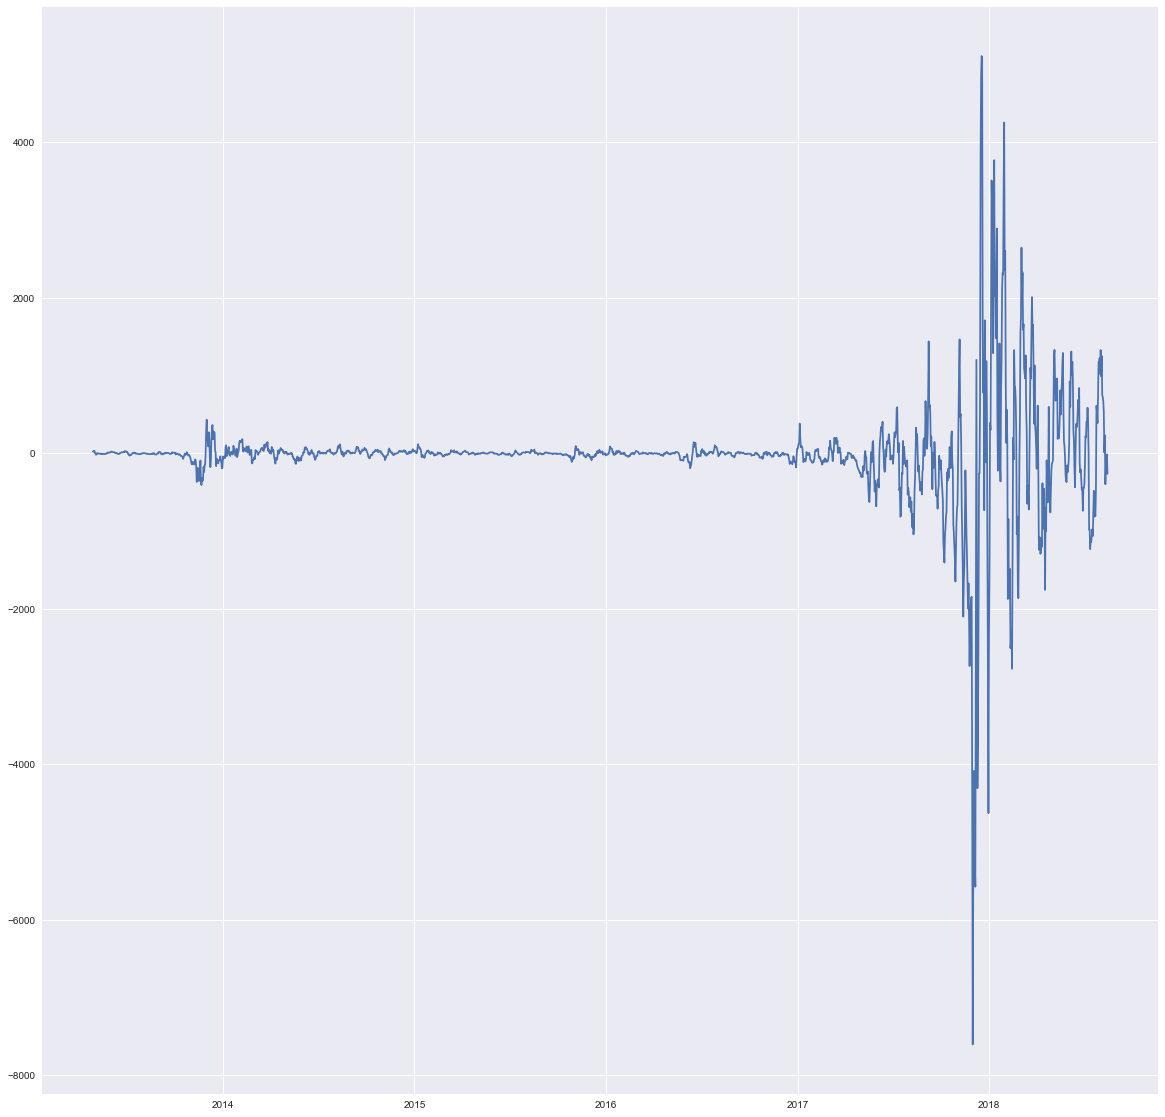

In [23]:
plt.figure(figsize=(20, 20))
plt.plot(df_bitcoin['日付開始'],df_bitcoin['difference_7day'])

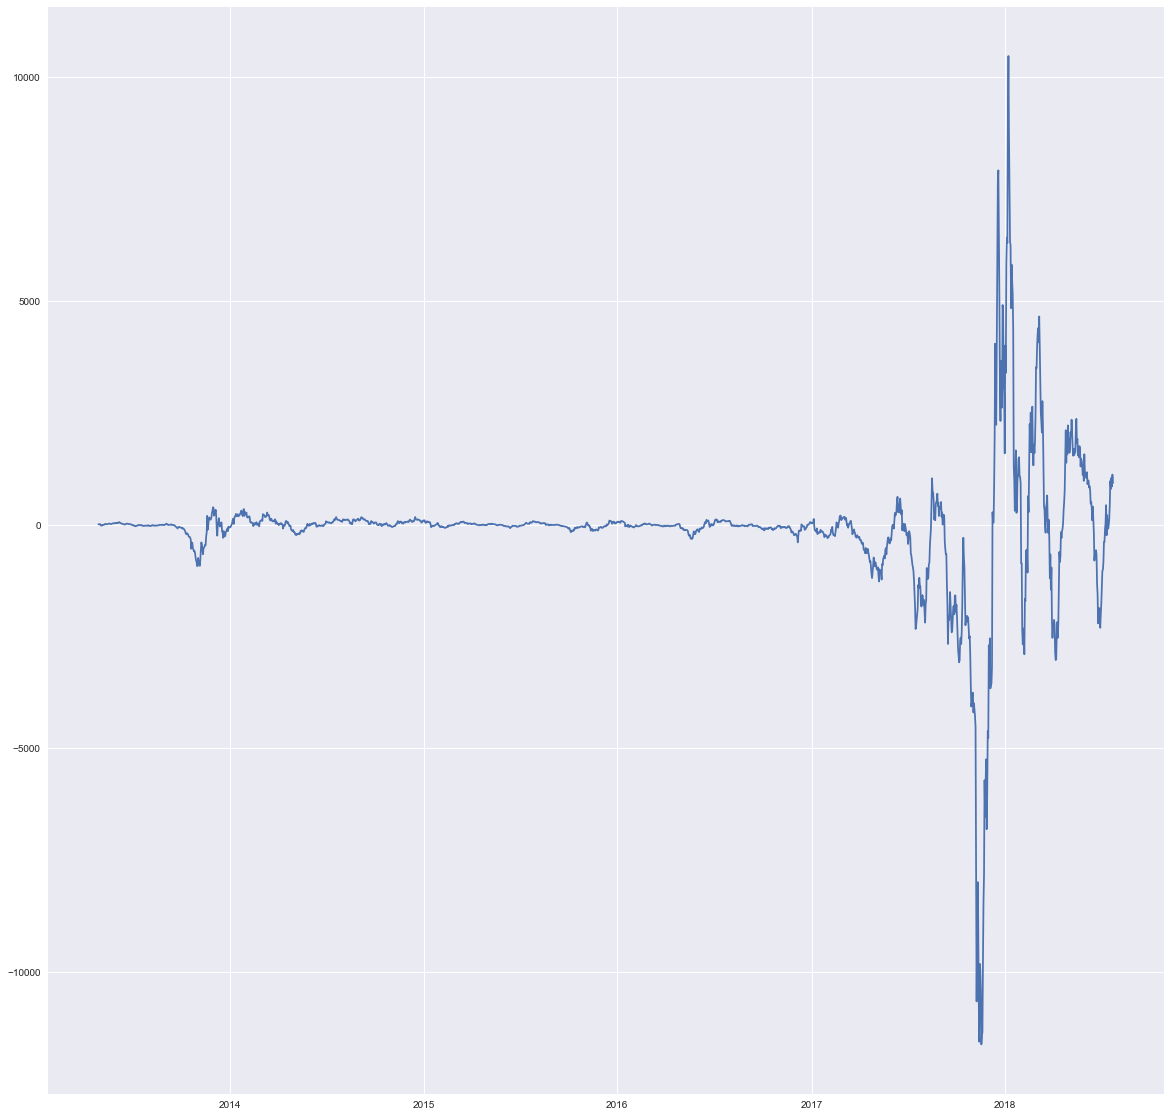

In [24]:
plt.figure(figsize=(20, 20))
plt.plot(df_bitcoin['日付開始'],df_bitcoin['difference_30day'])

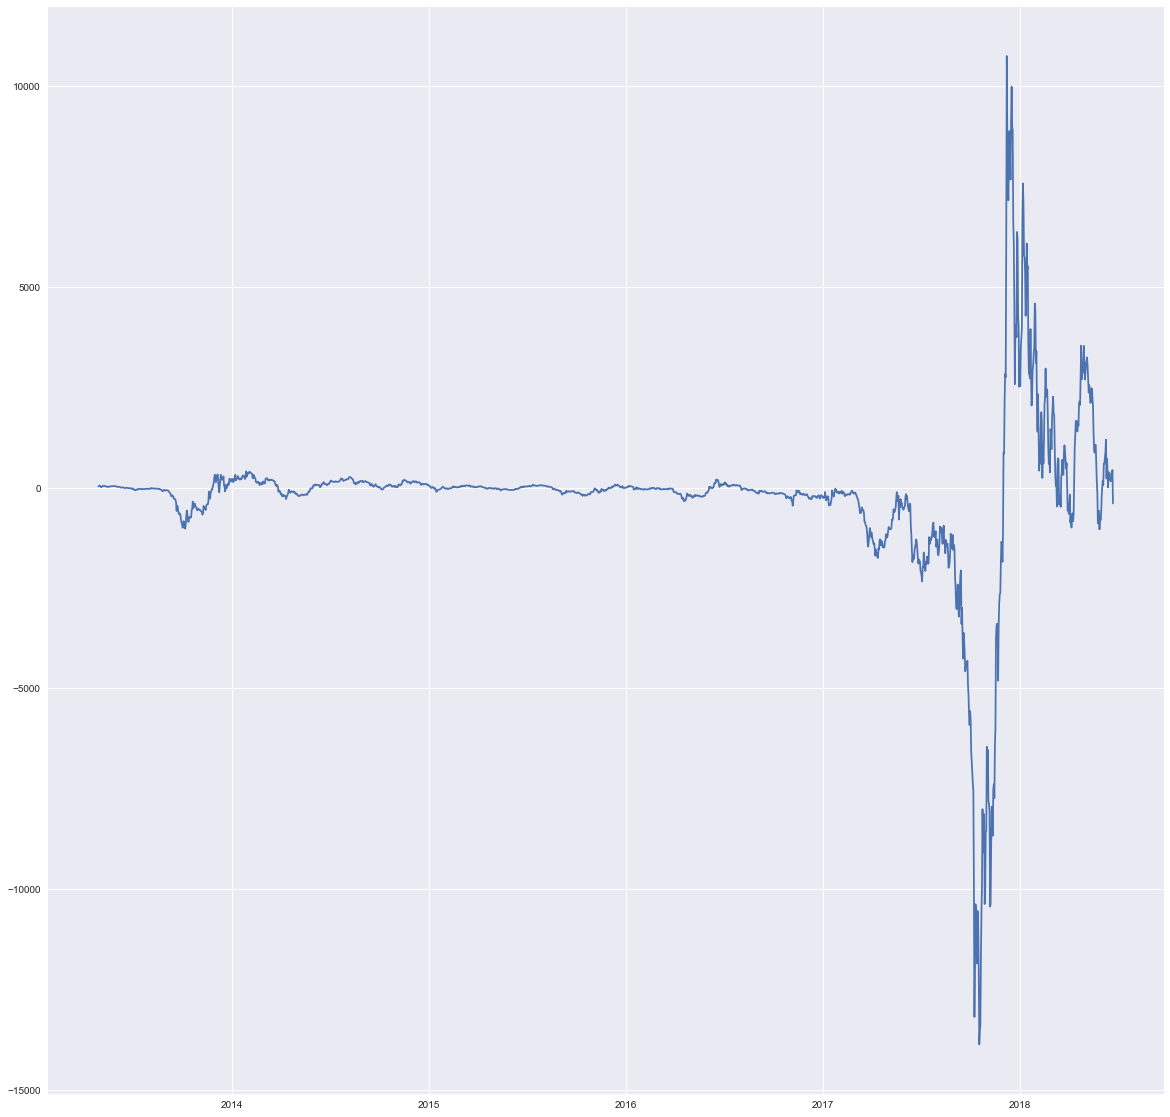

In [25]:
plt.figure(figsize=(20, 20))
plt.plot(df_bitcoin['日付開始'],df_bitcoin['difference_60day'])

## 移動平均

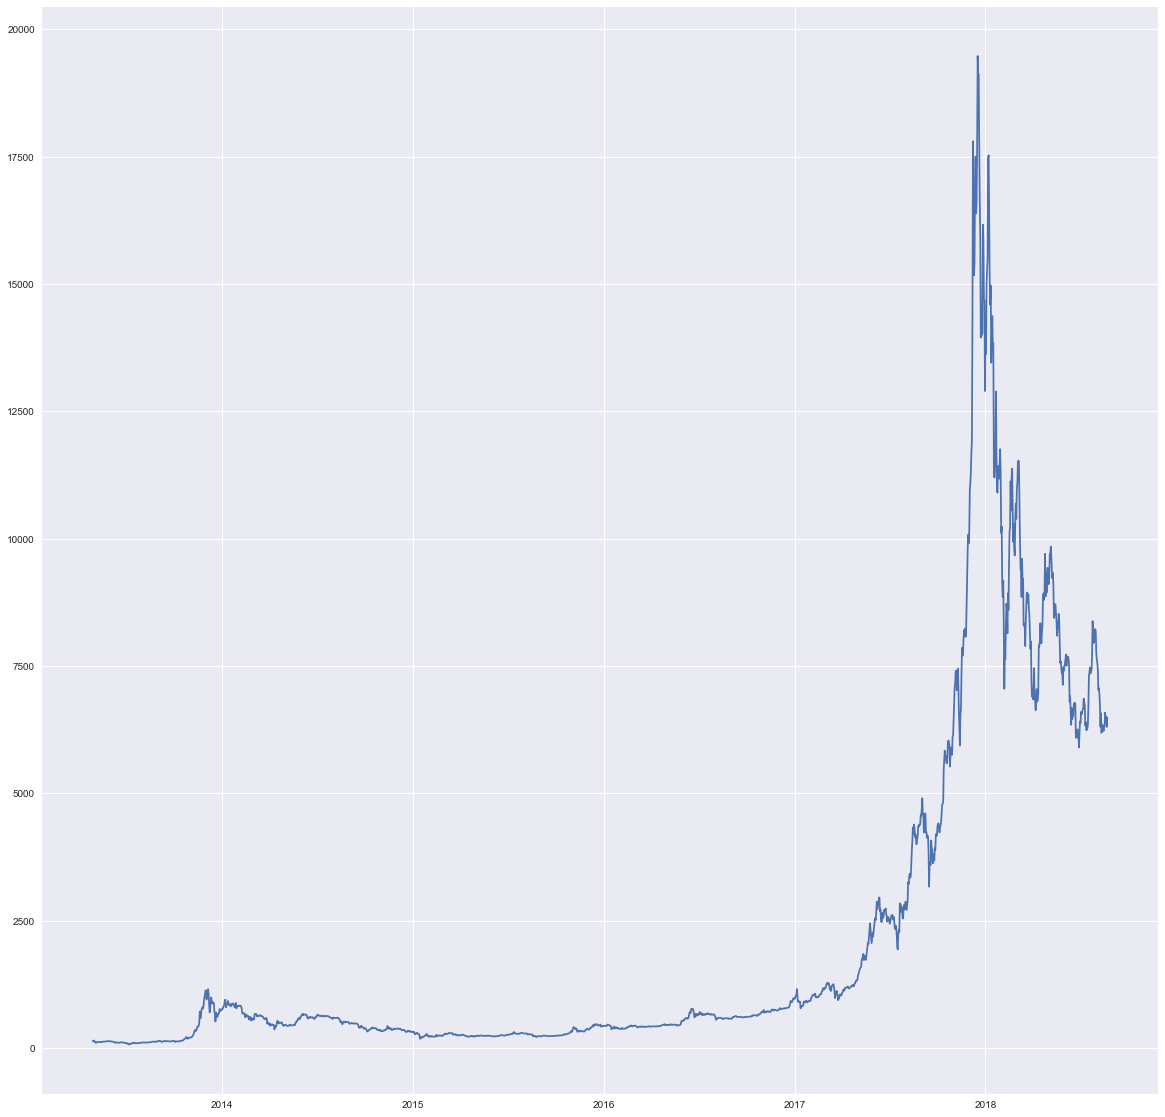

In [26]:
plt.figure(figsize=(20, 20))
plt.plot(df_bitcoin['日付開始'],df_bitcoin['rolling_mean_1d'])

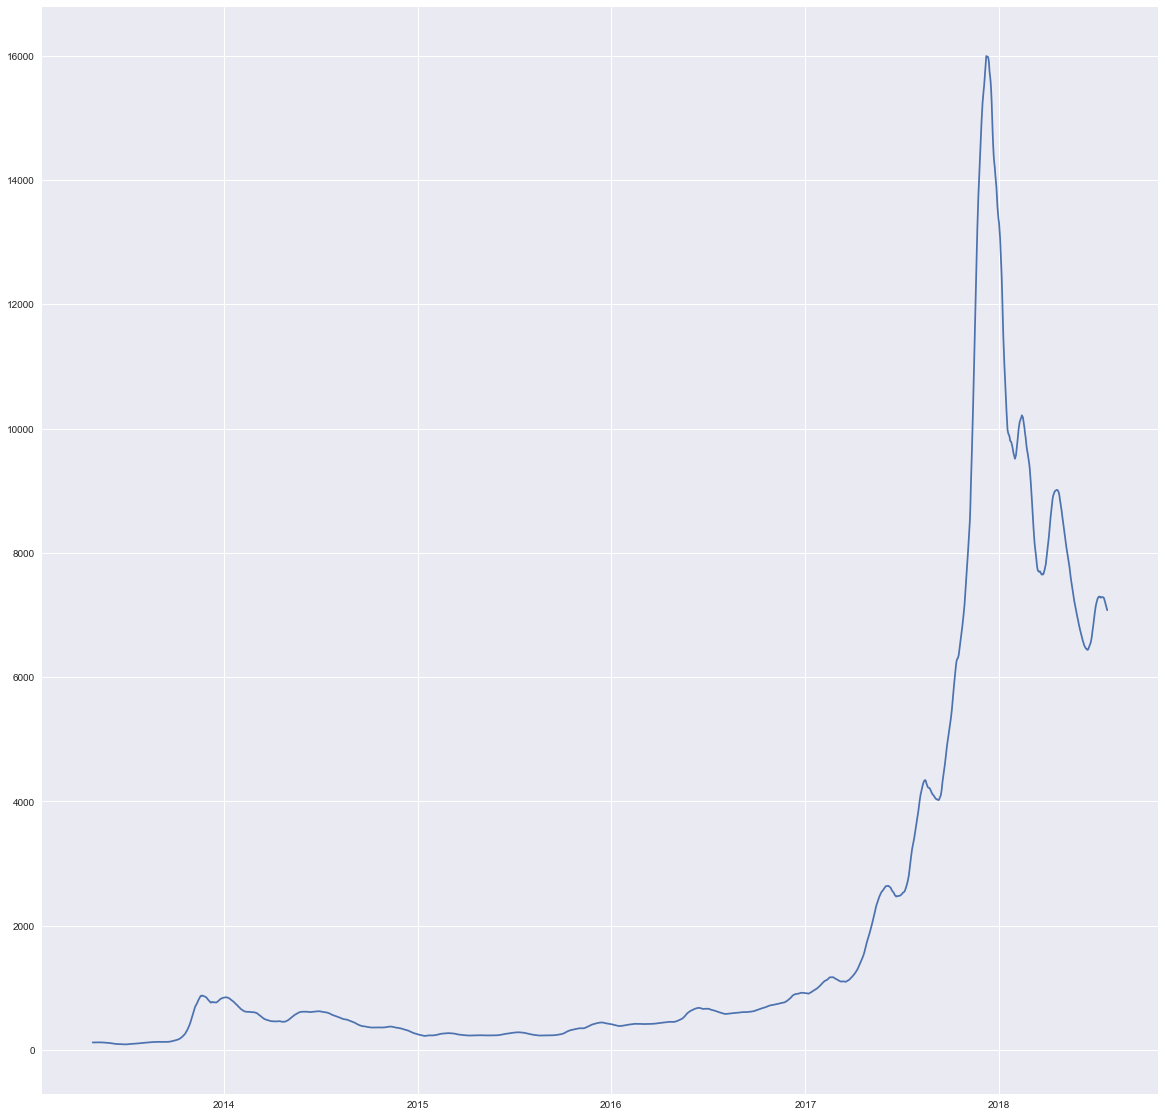

In [27]:
plt.figure(figsize=(20, 20))
plt.plot(df_bitcoin['日付開始'],df_bitcoin['rolling_mean_30d'])

# 変化率

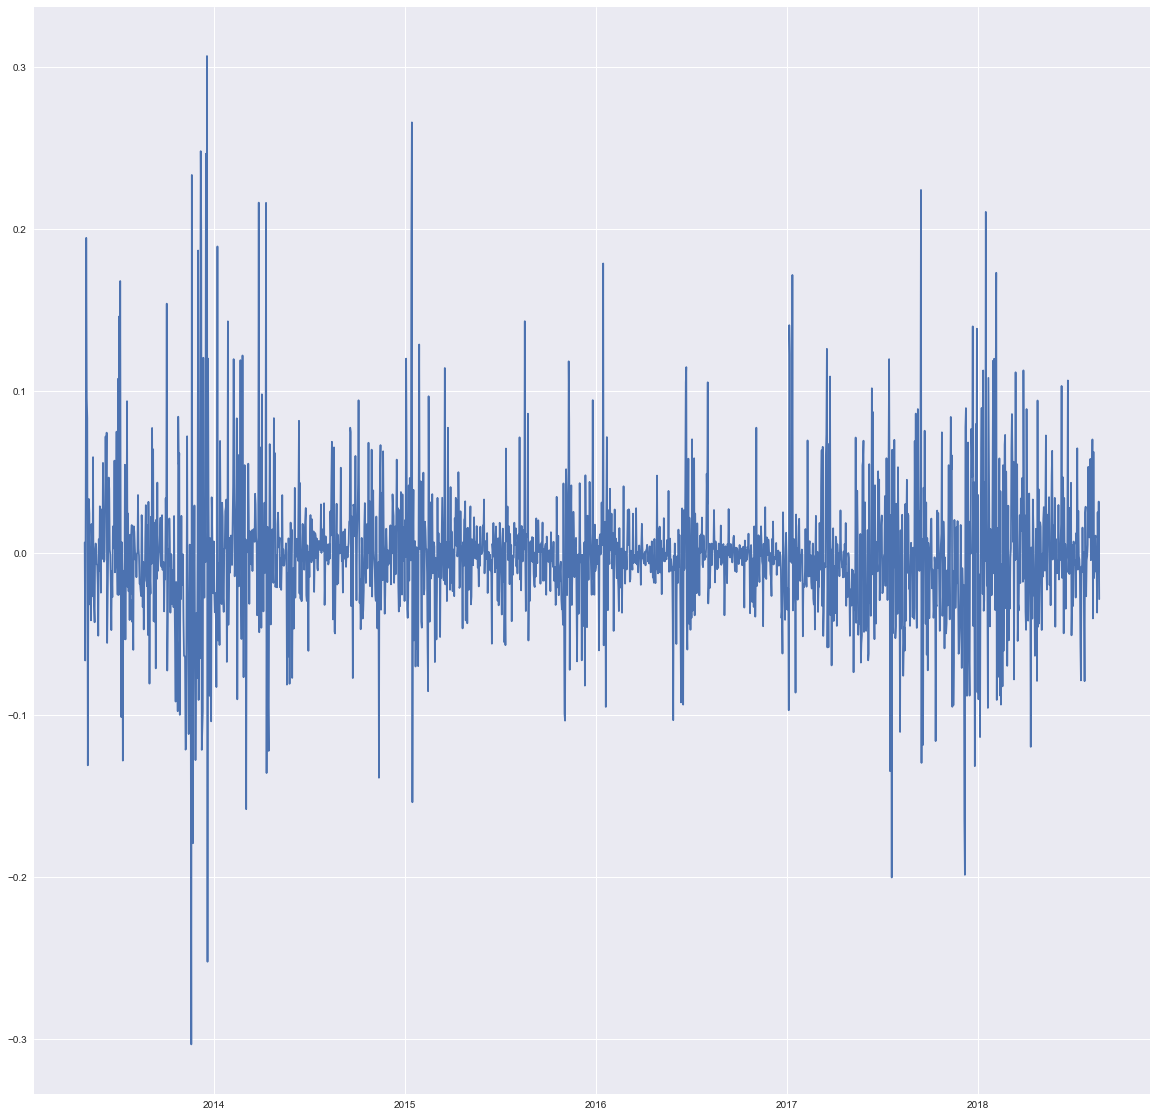

In [28]:
plt.figure(figsize=(20, 20))
plt.plot(df_bitcoin['日付開始'],df_bitcoin['pct_1d'])

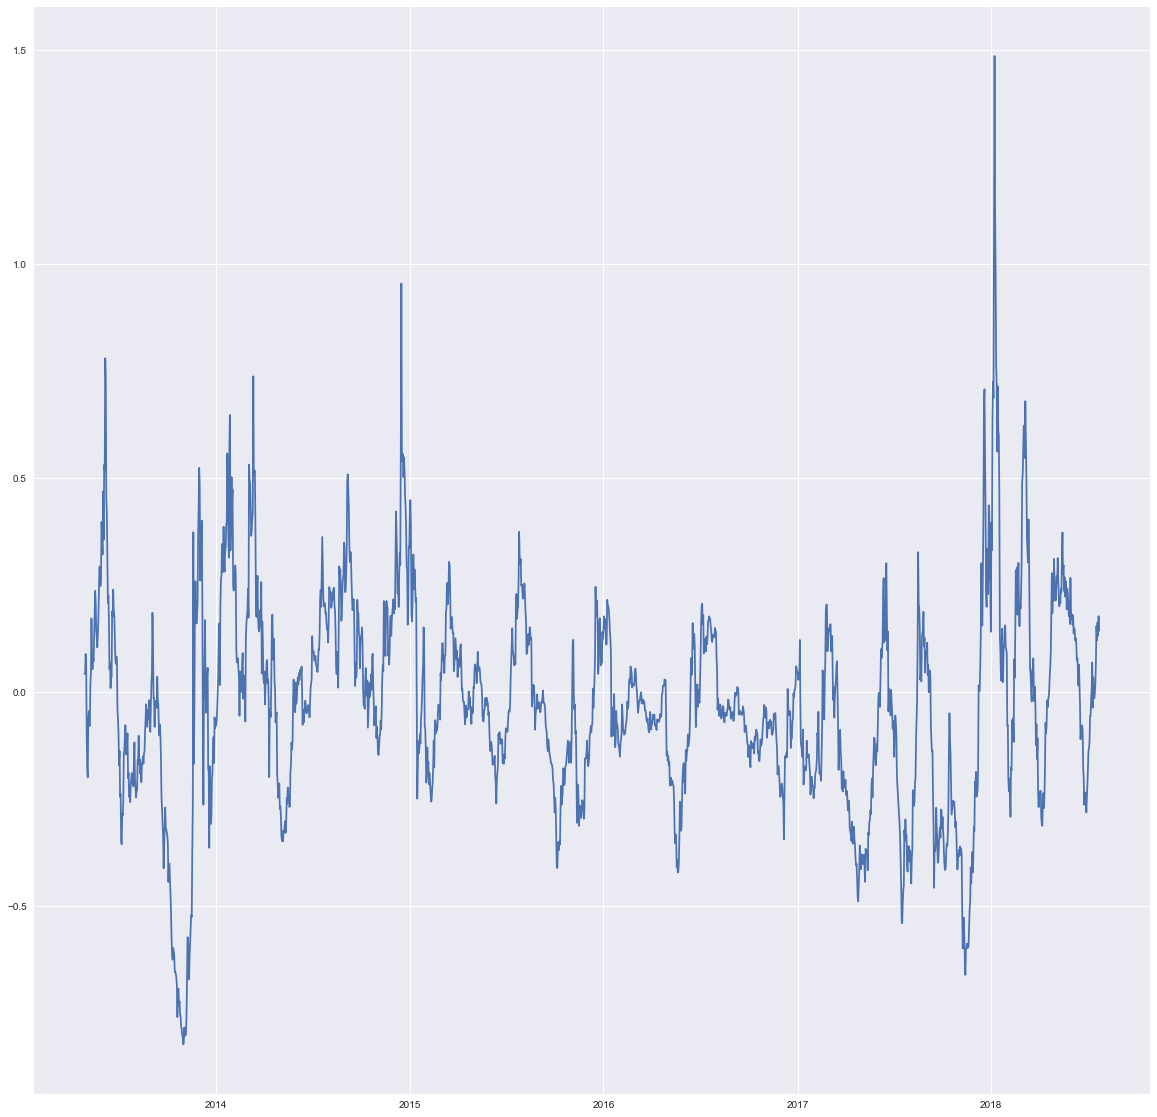

In [29]:
plt.figure(figsize=(20, 20))
plt.plot(df_bitcoin['日付開始'],df_bitcoin['pct_30d'])

### 自己相関

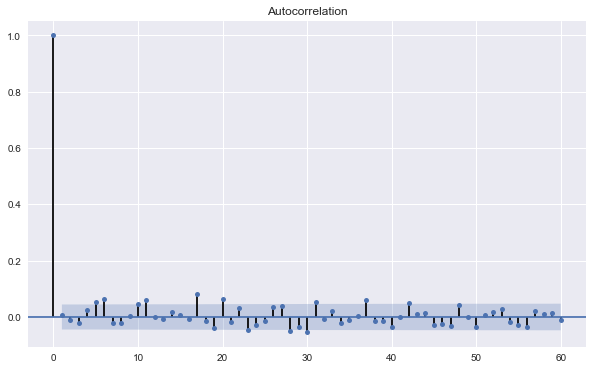

In [30]:
plt.figure(figsize=(7, 20))

diff = df_bitcoin['pct_1d'].dropna()
sm.graphics.tsa.plot_acf(diff, lags=60)
plt.show()

### 偏自己相関

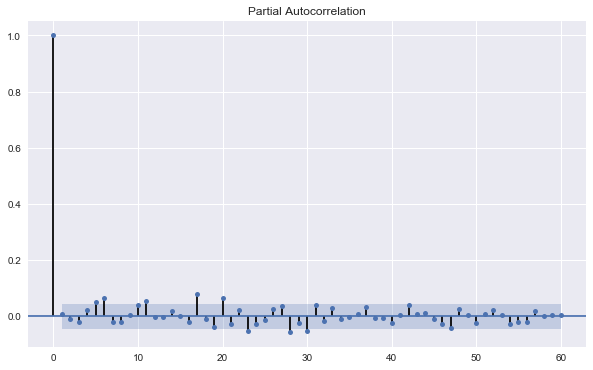

In [31]:
plt.figure(figsize=(7, 20))

diff = df_bitcoin['pct_1d'].dropna()
sm.graphics.tsa.plot_pacf(diff, lags=60)
plt.show()

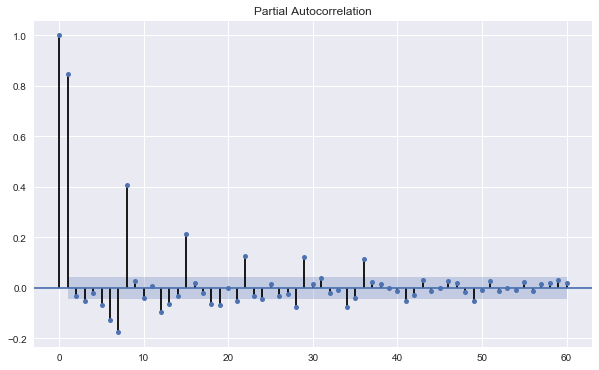

In [32]:
plt.figure(figsize=(7, 20))

diff = df_bitcoin['pct_7d'].dropna()
sm.graphics.tsa.plot_pacf(diff, lags=60)
plt.show()

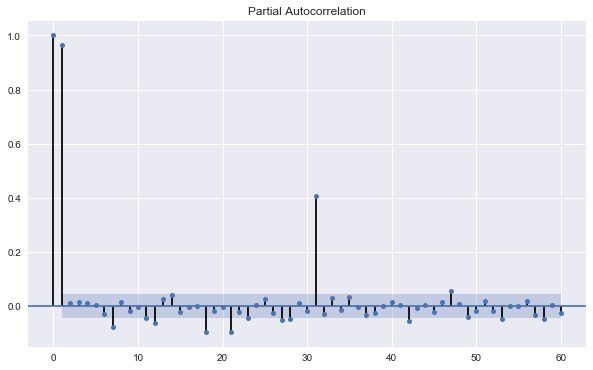

In [33]:
plt.figure(figsize=(7, 20))

diff = df_bitcoin['pct_30d'].dropna()
sm.graphics.tsa.plot_pacf(diff, lags=60)
plt.show()

In [34]:
diff = df_bitcoin['pct_1d'].dropna()


# ARIMA方式

## 一日後のやつ

In [164]:
# ADF検定（原型列で確認だけ）
res_ctt = sm.tsa.stattools.adfuller(diff, regression="ctt") # トレンド項あり（２次）、定数項あり
res_ct = sm.tsa.stattools.adfuller(diff, regression="ct") # トレンド項あり（１次）、定数項あり
res_c = sm.tsa.stattools.adfuller(diff, regression="c") # トレンド項なし、定数項あり
res_nc = sm.tsa.stattools.adfuller(diff, regression="nc") # トレンド項なし、定数項なし
print(res_ctt)
print(res_ct)
print(res_c)
print(res_nc)

(-8.30782202808177, 5.925235063635968e-11, 22, 1919, {'1%': -4.377178439896441, '5%': -3.8354708966744484, '10%': -3.5551684812229576}, -6462.919678875773)
(-8.309811933693283, 1.3751471338441887e-11, 22, 1919, {'1%': -3.963495351951755, '5%': -3.4127803184073815, '10%': -3.128398437422306}, -6464.913422772221)
(-8.288091360475807, 4.335559145180794e-13, 22, 1919, {'1%': -3.4337622297208146, '5%': -2.863047304445204, '10%': -2.567572430319552}, -6466.398379294082)
(-8.241180323552623, 9.229987039098704e-14, 22, 1919, {'1%': -2.5669060708946843, '5%': -1.9411408780817336, '10%': -1.6166823279784637}, -6467.625477913338)


In [176]:
diff=diff.values.tolist()

AttributeError: 'list' object has no attribute 'values'

In [166]:
res_selection = sm.tsa.arma_order_select_ic(diff, ic='aic', trend='nc')
res_selection

C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


{'aic':              0            1            2
 0          NaN -6555.794779 -6553.974130
 1 -6555.792417 -6553.821467 -6552.068956
 2 -6553.995272 -6552.105332 -6578.487789
 3 -6552.860756 -6551.259848 -6576.567482
 4 -6552.010107 -6558.935702 -6557.267726, 'aic_min_order': (2, 2)}

In [167]:
sarimax = sm.tsa.SARIMAX(diff, 
                        order=(2, 1, 2),
                        seasonal_order=(1, 1, 1, 17),
                        enforce_stationarity = False,
                        enforce_invertibility = False
                        ).fit()

In [168]:
sarimax_resid = sarimax.resid # モデルの残差成分


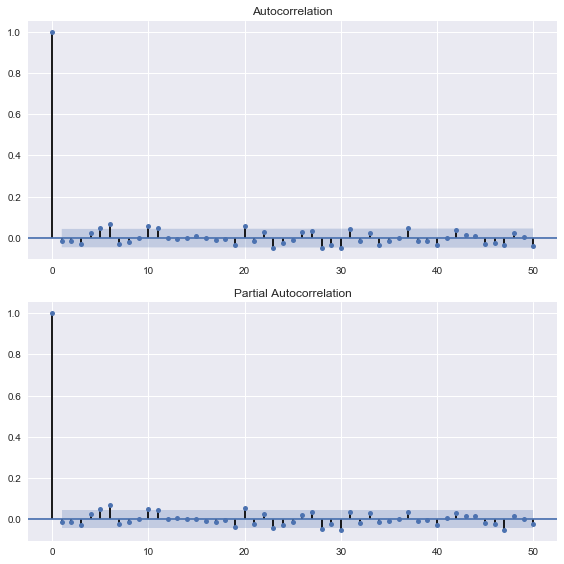

In [169]:
# モデル残差のコレログラム
fig = plt.figure(figsize=(8, 8))

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid, lags=50, ax=ax1) #ACF計算とグラフ自動作成

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid, lags=50, ax=ax2) #PACF計算とグラフ自動作成

plt.tight_layout() # グラフ間スキマ調整

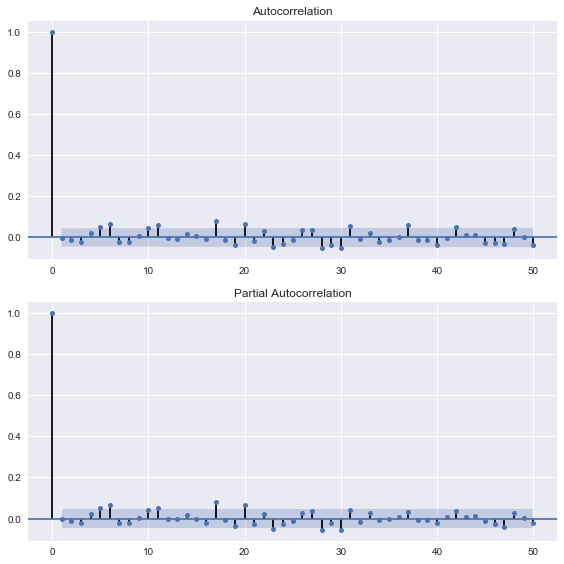

In [170]:
# SRIMAモデル（試しに）季節調整なし
sarimax_noseasonal = sm.tsa.SARIMAX(diff, 
                        order=(2, 1, 2),
                        seasonal_order=(0, 0, 0, 0),
                        enforce_stationarity = False,
                        enforce_invertibility = False
                        ).fit()

sarimax_noseasonal_resid = sarimax_noseasonal.resid # 残差成分

fig = plt.figure(figsize=(8, 8))

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_noseasonal_resid, lags=50, ax=ax1) #ACF計算とグラフ自動作成

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_noseasonal_resid, lags=50, ax=ax2) #PACF計算とグラフ自動作成

plt.tight_layout() # グラフ間スキマ調整

In [171]:
print(sarimax.aic) 
print(sarimax_noseasonal.aic) 

-6330.481601563466
-6527.931977090535


In [172]:
# SARIMAパラメター最適化（総当たりチェック）


# パラメータ範囲
# order(p, d, q)
min_p = 1; max_p = 3 # min_pは1以上を指定しないとエラー
min_d = 0; max_d = 1
min_q = 0; max_q = 3 

# seasonal_order(sp, sd, sq)
min_sp = 0; max_sp = 1
min_sd = 0; max_sd = 1
min_sq = 0; max_sq = 1

test_pattern = (max_p - min_p +1)*(max_q - min_q + 1)*(max_d - min_d + 1)*(max_sp - min_sp + 1)*(max_sq - min_sq + 1)*(max_sd - min_sd + 1)
print("pattern:", test_pattern)

sfq = 12 # seasonal_order周期パラメータ
ts = diff # 時系列データ

test_results = pd.DataFrame(index=range(test_pattern), columns=["model_parameters", "aic"])
num = 0
for p in range(min_p, max_p + 1):
    for d in range(min_d, max_d + 1):
        for q in range(min_q, max_q + 1):
            for sp in range(min_sp, max_sp + 1):
                for sd in range(min_sd, max_sd + 1):
                    for sq in range(min_sq, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(
                            ts, order=(p, d, q), 
                            seasonal_order=(sp, sd, sq, sfq), 
                            enforce_stationarity = False, 
                            enforce_invertibility = False
                        ).fit()
                        test_results.iloc[num]["model_parameters"] = "order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), seasonal_order=("+ str(sp) + ","+ str(sd) + "," + str(sq) + ")"
                        test_results.iloc[num]["aic"] = sarima.aic
                        print(num,'/', test_pattern-1, test_results.iloc[num]["model_parameters"],  test_results.iloc[num]["aic"] )
                        num = num + 1

# 結果（最小AiC）
print("best[aic] parameter ********")
print(test_results[test_results.aic == min(test_results.aic)])

pattern: 192
0 / 191 order=(1,0,0), seasonal_order=(0,0,0) -6551.8226867995445
1 / 191 order=(1,0,0), seasonal_order=(0,0,1) -6502.0387740987735
2 / 191 order=(1,0,0), seasonal_order=(0,1,0) -5184.108167984807
3 / 191 order=(1,0,0), seasonal_order=(0,1,1) -6406.874596139774
4 / 191 order=(1,0,0), seasonal_order=(1,0,0) -6502.030864304221
5 / 191 order=(1,0,0), seasonal_order=(1,0,1) -6499.809533252172
6 / 191 order=(1,0,0), seasonal_order=(1,1,0) -5653.22242152803
7 / 191 order=(1,0,0), seasonal_order=(1,1,1) -6396.586828347088
8 / 191 order=(1,0,1), seasonal_order=(0,0,0) -6547.608716940056
9 / 191 order=(1,0,1), seasonal_order=(0,0,1) -6499.818315410359
10 / 191 order=(1,0,1), seasonal_order=(0,1,0) -5243.310160994734
11 / 191 order=(1,0,1), seasonal_order=(0,1,1) -6404.934129958194
12 / 191 order=(1,0,1), seasonal_order=(1,0,0) -6501.939356927482
13 / 191 order=(1,0,1), seasonal_order=(1,0,1) -6497.9846729329665
14 / 191 order=(1,0,1), seasonal_order=(1,1,0) -5683.317692061309
15 / 

C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


47 / 191 order=(1,1,1), seasonal_order=(1,1,1) -6376.19564885126
48 / 191 order=(1,1,2), seasonal_order=(0,0,0) -6529.905034330861
49 / 191 order=(1,1,2), seasonal_order=(0,0,1) -6481.139166854228
50 / 191 order=(1,1,2), seasonal_order=(0,1,0) -5162.649722961034
51 / 191 order=(1,1,2), seasonal_order=(0,1,1) -6381.500883607671
52 / 191 order=(1,1,2), seasonal_order=(1,0,0) -6490.0531089121005
53 / 191 order=(1,1,2), seasonal_order=(1,0,1) -6479.45410999092
54 / 191 order=(1,1,2), seasonal_order=(1,1,0) -5640.831234722092


C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


55 / 191 order=(1,1,2), seasonal_order=(1,1,1) -6371.015110938882
56 / 191 order=(1,1,3), seasonal_order=(0,0,0) -6524.234733268586
57 / 191 order=(1,1,3), seasonal_order=(0,0,1) -6475.7419252729815
58 / 191 order=(1,1,3), seasonal_order=(0,1,0) -5237.551843013633


C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


59 / 191 order=(1,1,3), seasonal_order=(0,1,1) -6377.717691431968
60 / 191 order=(1,1,3), seasonal_order=(1,0,0) -6488.029113463195
61 / 191 order=(1,1,3), seasonal_order=(1,0,1) -6474.1609699475575
62 / 191 order=(1,1,3), seasonal_order=(1,1,0) -5637.551158285156
63 / 191 order=(1,1,3), seasonal_order=(1,1,1) -6375.379321828809
64 / 191 order=(2,0,0), seasonal_order=(0,0,0) -6546.15649234812
65 / 191 order=(2,0,0), seasonal_order=(0,0,1) -6500.253687686472
66 / 191 order=(2,0,0), seasonal_order=(0,1,0) -5182.237119337185
67 / 191 order=(2,0,0), seasonal_order=(0,1,1) -6404.550539442512
68 / 191 order=(2,0,0), seasonal_order=(1,0,0) -6498.386371839983
69 / 191 order=(2,0,0), seasonal_order=(1,0,1) -6496.500544033022
70 / 191 order=(2,0,0), seasonal_order=(1,1,0) -5652.893168539259
71 / 191 order=(2,0,0), seasonal_order=(1,1,1) -6393.533877560827
72 / 191 order=(2,0,1), seasonal_order=(0,0,0) -6543.432206085323
73 / 191 order=(2,0,1), seasonal_order=(0,0,1) -6496.686988845264
74 / 191 o

C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


82 / 191 order=(2,0,2), seasonal_order=(0,1,0) -5324.103871799329
83 / 191 order=(2,0,2), seasonal_order=(0,1,1) -6394.815145840039
84 / 191 order=(2,0,2), seasonal_order=(1,0,0) -6496.663418062781
85 / 191 order=(2,0,2), seasonal_order=(1,0,1) -6490.893650879126


C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


86 / 191 order=(2,0,2), seasonal_order=(1,1,0) -5744.991656934557


C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


87 / 191 order=(2,0,2), seasonal_order=(1,1,1) -6388.920618612841
88 / 191 order=(2,0,3), seasonal_order=(0,0,0) -6555.712479180309
89 / 191 order=(2,0,3), seasonal_order=(0,0,1) -6508.2535595498075
90 / 191 order=(2,0,3), seasonal_order=(0,1,0) -5331.854312981168


C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


91 / 191 order=(2,0,3), seasonal_order=(0,1,1) -6406.837591991482
92 / 191 order=(2,0,3), seasonal_order=(1,0,0) -6513.023673627218
93 / 191 order=(2,0,3), seasonal_order=(1,0,1) -6506.277067476616


C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


94 / 191 order=(2,0,3), seasonal_order=(1,1,0) -5748.274871251702
95 / 191 order=(2,0,3), seasonal_order=(1,1,1) -6393.228954854275
96 / 191 order=(2,1,0), seasonal_order=(0,0,0) -5960.054297524921
97 / 191 order=(2,1,0), seasonal_order=(0,0,1) -5920.504925471266
98 / 191 order=(2,1,0), seasonal_order=(0,1,0) -4564.011145182907
99 / 191 order=(2,1,0), seasonal_order=(0,1,1) -5825.543762630729
100 / 191 order=(2,1,0), seasonal_order=(1,0,0) -5916.345301764408
101 / 191 order=(2,1,0), seasonal_order=(1,0,1) -5914.552645582103
102 / 191 order=(2,1,0), seasonal_order=(1,1,0) -5049.731703515285
103 / 191 order=(2,1,0), seasonal_order=(1,1,1) -5814.859570009288
104 / 191 order=(2,1,1), seasonal_order=(0,0,0) -6533.1966254112085
105 / 191 order=(2,1,1), seasonal_order=(0,0,1) -6484.009256206454
106 / 191 order=(2,1,1), seasonal_order=(0,1,0) -5170.069245885909
107 / 191 order=(2,1,1), seasonal_order=(0,1,1) -6385.624453393752
108 / 191 order=(2,1,1), seasonal_order=(1,0,0) -6485.206125573894


C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


118 / 191 order=(2,1,2), seasonal_order=(1,1,0) -5638.4820544109925
119 / 191 order=(2,1,2), seasonal_order=(1,1,1) -6369.019341473542
120 / 191 order=(2,1,3), seasonal_order=(0,0,0) -6527.156595012929
121 / 191 order=(2,1,3), seasonal_order=(0,0,1) -6479.659002417975
122 / 191 order=(2,1,3), seasonal_order=(0,1,0) -5195.113267661296


C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


123 / 191 order=(2,1,3), seasonal_order=(0,1,1) -6381.821161762298


C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


124 / 191 order=(2,1,3), seasonal_order=(1,0,0) -6486.4184861883605
125 / 191 order=(2,1,3), seasonal_order=(1,0,1) -6477.70031986211


C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


126 / 191 order=(2,1,3), seasonal_order=(1,1,0) -5634.388340104639


C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


127 / 191 order=(2,1,3), seasonal_order=(1,1,1) -6363.245262859769
128 / 191 order=(3,0,0), seasonal_order=(0,0,0) -6540.723452518336
129 / 191 order=(3,0,0), seasonal_order=(0,0,1) -6499.079283838849
130 / 191 order=(3,0,0), seasonal_order=(0,1,0) -5178.390799601841
131 / 191 order=(3,0,0), seasonal_order=(0,1,1) -6402.367157919056
132 / 191 order=(3,0,0), seasonal_order=(1,0,0) -6493.315823326979
133 / 191 order=(3,0,0), seasonal_order=(1,0,1) -6491.328010526125
134 / 191 order=(3,0,0), seasonal_order=(1,1,0) -5648.428237720833
135 / 191 order=(3,0,0), seasonal_order=(1,1,1) -6388.692239973084
136 / 191 order=(3,0,1), seasonal_order=(0,0,0) -6538.73226571146
137 / 191 order=(3,0,1), seasonal_order=(0,0,1) -6495.198681273817
138 / 191 order=(3,0,1), seasonal_order=(0,1,0) -5176.342032392578
139 / 191 order=(3,0,1), seasonal_order=(0,1,1) -6400.119955887834
140 / 191 order=(3,0,1), seasonal_order=(1,0,0) -6491.328226363066
141 / 191 order=(3,0,1), seasonal_order=(1,0,1) -6489.444109699

C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


147 / 191 order=(3,0,2), seasonal_order=(0,1,1) -6402.6367705016255
148 / 191 order=(3,0,2), seasonal_order=(1,0,0) -6491.630348950265
149 / 191 order=(3,0,2), seasonal_order=(1,0,1) -6489.928915001687


C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


150 / 191 order=(3,0,2), seasonal_order=(1,1,0) -5707.052966205254
151 / 191 order=(3,0,2), seasonal_order=(1,1,1) -6391.996509559773
152 / 191 order=(3,0,3), seasonal_order=(0,0,0) -6554.020472618327
153 / 191 order=(3,0,3), seasonal_order=(0,0,1) -6506.078541465523


C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


154 / 191 order=(3,0,3), seasonal_order=(0,1,0) -5319.920170615735
155 / 191 order=(3,0,3), seasonal_order=(0,1,1) -6415.302242998452


C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


156 / 191 order=(3,0,3), seasonal_order=(1,0,0) -6508.37367186214


C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


157 / 191 order=(3,0,3), seasonal_order=(1,0,1) -6504.1196295611635
158 / 191 order=(3,0,3), seasonal_order=(1,1,0) -5714.478545800662
159 / 191 order=(3,0,3), seasonal_order=(1,1,1) -6404.430925263013
160 / 191 order=(3,1,0), seasonal_order=(0,0,0) -6110.499916758019
161 / 191 order=(3,1,0), seasonal_order=(0,0,1) -6072.936076442934
162 / 191 order=(3,1,0), seasonal_order=(0,1,0) -4741.675214477037
163 / 191 order=(3,1,0), seasonal_order=(0,1,1) -5978.010217477569
164 / 191 order=(3,1,0), seasonal_order=(1,0,0) -6064.813569135529
165 / 191 order=(3,1,0), seasonal_order=(1,0,1) -6062.773685396279
166 / 191 order=(3,1,0), seasonal_order=(1,1,0) -5208.004680189144
167 / 191 order=(3,1,0), seasonal_order=(1,1,1) -5963.9693708676
168 / 191 order=(3,1,1), seasonal_order=(0,0,0) -6527.793777868042
169 / 191 order=(3,1,1), seasonal_order=(0,0,1) -6482.843038540017
170 / 191 order=(3,1,1), seasonal_order=(0,1,0) -5166.207976999251
171 / 191 order=(3,1,1), seasonal_order=(0,1,1) -6384.165786959

C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


173 / 191 order=(3,1,1), seasonal_order=(1,0,1) -6478.473886567659
174 / 191 order=(3,1,1), seasonal_order=(1,1,0) -5636.185199866824
175 / 191 order=(3,1,1), seasonal_order=(1,1,1) -6370.780193677399
176 / 191 order=(3,1,2), seasonal_order=(0,0,0) -6526.891615588327
177 / 191 order=(3,1,2), seasonal_order=(0,0,1) -6478.5745100406075


C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


178 / 191 order=(3,1,2), seasonal_order=(0,1,0) -5165.399317320026
179 / 191 order=(3,1,2), seasonal_order=(0,1,1) -6379.104416551654
180 / 191 order=(3,1,2), seasonal_order=(1,0,0) -6478.894789013428


C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


181 / 191 order=(3,1,2), seasonal_order=(1,0,1) -6476.901299588695
182 / 191 order=(3,1,2), seasonal_order=(1,1,0) -5634.335113841989


C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


183 / 191 order=(3,1,2), seasonal_order=(1,1,1) -6369.15041761947


C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


184 / 191 order=(3,1,3), seasonal_order=(0,0,0) -6527.585971696961
185 / 191 order=(3,1,3), seasonal_order=(0,0,1) -6478.292581202903
186 / 191 order=(3,1,3), seasonal_order=(0,1,0) -5193.129877872064


C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


187 / 191 order=(3,1,3), seasonal_order=(0,1,1) -6378.817867091235
188 / 191 order=(3,1,3), seasonal_order=(1,0,0) -6483.578768071415
189 / 191 order=(3,1,3), seasonal_order=(1,0,1) -6477.177681604156


C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


190 / 191 order=(3,1,3), seasonal_order=(1,1,0) -5632.03153844723
191 / 191 order=(3,1,3), seasonal_order=(1,1,1) -6366.808440371491
best[aic] parameter ********
                         model_parameters      aic
88  order=(2,0,3), seasonal_order=(0,0,0) -6555.71


In [181]:
print("best[aic] parameter ********")
print(test_results[test_results.aic == min(test_results.aic)])
print(test_results[test_results.aic == max(test_results.aic)])

best[aic] parameter ********
                         model_parameters      aic
88  order=(2,0,3), seasonal_order=(0,0,0) -6555.71
                         model_parameters      aic
34  order=(1,1,0), seasonal_order=(0,1,0) -4332.15


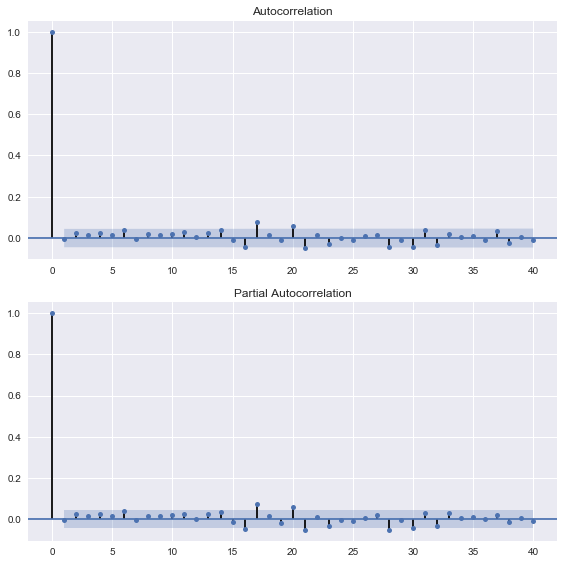

In [182]:
# SRIMAモデル（ちょっとだけパラメータ最適化・総当たりaicベストを適用）
sarimax_optimization = sm.tsa.SARIMAX(diff, 
                        order=(2, 0, 3),
                        seasonal_order=(0, 0, 0, 17),
                        enforce_stationarity = False,
                        enforce_invertibility = False
                        ).fit()

sarimax_optimization_resid = sarimax_optimization.resid # 残差成分

fig = plt.figure(figsize=(8, 8))


# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_optimization_resid, lags=40, ax=ax1) #ACF計算とグラフ自動作成

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_optimization_resid, lags=40, ax=ax2) #PACF計算とグラフ自動作成

plt.tight_layout() # グラフ間スキマ調整

In [183]:
passengers_train = df_bitcoin[df_bitcoin['日付開始']<'2018-05-22']
passengers_train = passengers_train[['pct_1d','日付開始']]
passengers_train=passengers_train.reset_index()
passengers_train=passengers_train.drop('index',axis=1)
passengers_train=passengers_train.set_index(keys='日付開始')
print(passengers_train.head())
print(passengers_train.tail())
print(passengers_train.isnull().sum())

              pct_1d
日付開始                
2018-05-21  0.012169
2018-05-20 -0.032308
2018-05-19  0.001060
2018-05-18 -0.019853
2018-05-17  0.034383
              pct_1d
日付開始                
2013-05-02  0.095341
2013-05-01  0.194363
2013-04-30  0.035971
2013-04-29 -0.066389
2013-04-28  0.006397
pct_1d    0
dtype: int64


In [184]:
passengers_test = df_bitcoin[df_bitcoin['日付開始']>='2018-05-22']
passengers_test = passengers_test[['pct_1d','日付開始']]
passengers_test=passengers_test.reset_index()
passengers_test=passengers_test.drop('index',axis=1)
passengers_test=passengers_test.set_index(keys='日付開始')
passengers_test = passengers_test['pct_1d'].dropna()
print(passengers_test.head())
print(passengers_test.tail())
print(passengers_test.isnull().sum())

日付開始
2018-08-21   -0.028550
2018-08-20    0.031652
2018-08-19   -0.011990
2018-08-18    0.025046
2018-08-17   -0.036838
Name: pct_1d, dtype: float64
日付開始
2018-05-26    0.016897
2018-05-25    0.014135
2018-05-24   -0.004107
2018-05-23    0.062948
2018-05-22    0.047628
Name: pct_1d, dtype: float64
0


In [185]:
# SRIMAモデル（テストデータを2年分除いてモデル作成）
sarimax_train = sm.tsa.SARIMAX(passengers_train, 
                        order=(2, 0, 3),
                        seasonal_order=(0, 0, 0, 17),
                        enforce_stationarity = False,
                        enforce_invertibility = False
                        ).fit()

In [186]:
sarimax_train_pred = sarimax_train.predict() # テストデータ2年分予測
sarimax_train_pred

2018-05-21    0.000000
2018-05-20    0.008955
2018-05-19   -0.035619
2018-05-18    0.032223
2018-05-17   -0.015641
2018-05-16    0.015191
2018-05-15   -0.002542
2018-05-14   -0.012896
2018-05-13   -0.015700
2018-05-12   -0.003578
2018-05-11    0.013842
2018-05-10    0.018350
2018-05-09   -0.009203
2018-05-08   -0.027038
2018-05-07   -0.008605
2018-05-06    0.015986
2018-05-05    0.015314
2018-05-04   -0.006190
2018-05-03   -0.016192
2018-05-02   -0.007149
2018-05-01    0.012997
2018-04-30    0.017382
2018-04-29   -0.000028
2018-04-28   -0.017256
2018-04-27   -0.012548
2018-04-26    0.010415
2018-04-25    0.015767
2018-04-24    0.005879
2018-04-23   -0.016545
2018-04-22   -0.013560
                ...   
2013-05-27    0.001517
2013-05-26   -0.004072
2013-05-25   -0.005130
2013-05-24    0.000216
2013-05-23    0.004729
2013-05-22    0.004297
2013-05-21   -0.000564
2013-05-20   -0.004183
2013-05-19   -0.002276
2013-05-18    0.002276
2013-05-17    0.003648
2013-05-16    0.000273
2013-05-15 

In [187]:
sarimax_train_pred.head()

2018-05-21    0.000000
2018-05-20    0.008955
2018-05-19   -0.035619
2018-05-18    0.032223
2018-05-17   -0.015641
Freq: -1D, dtype: float64

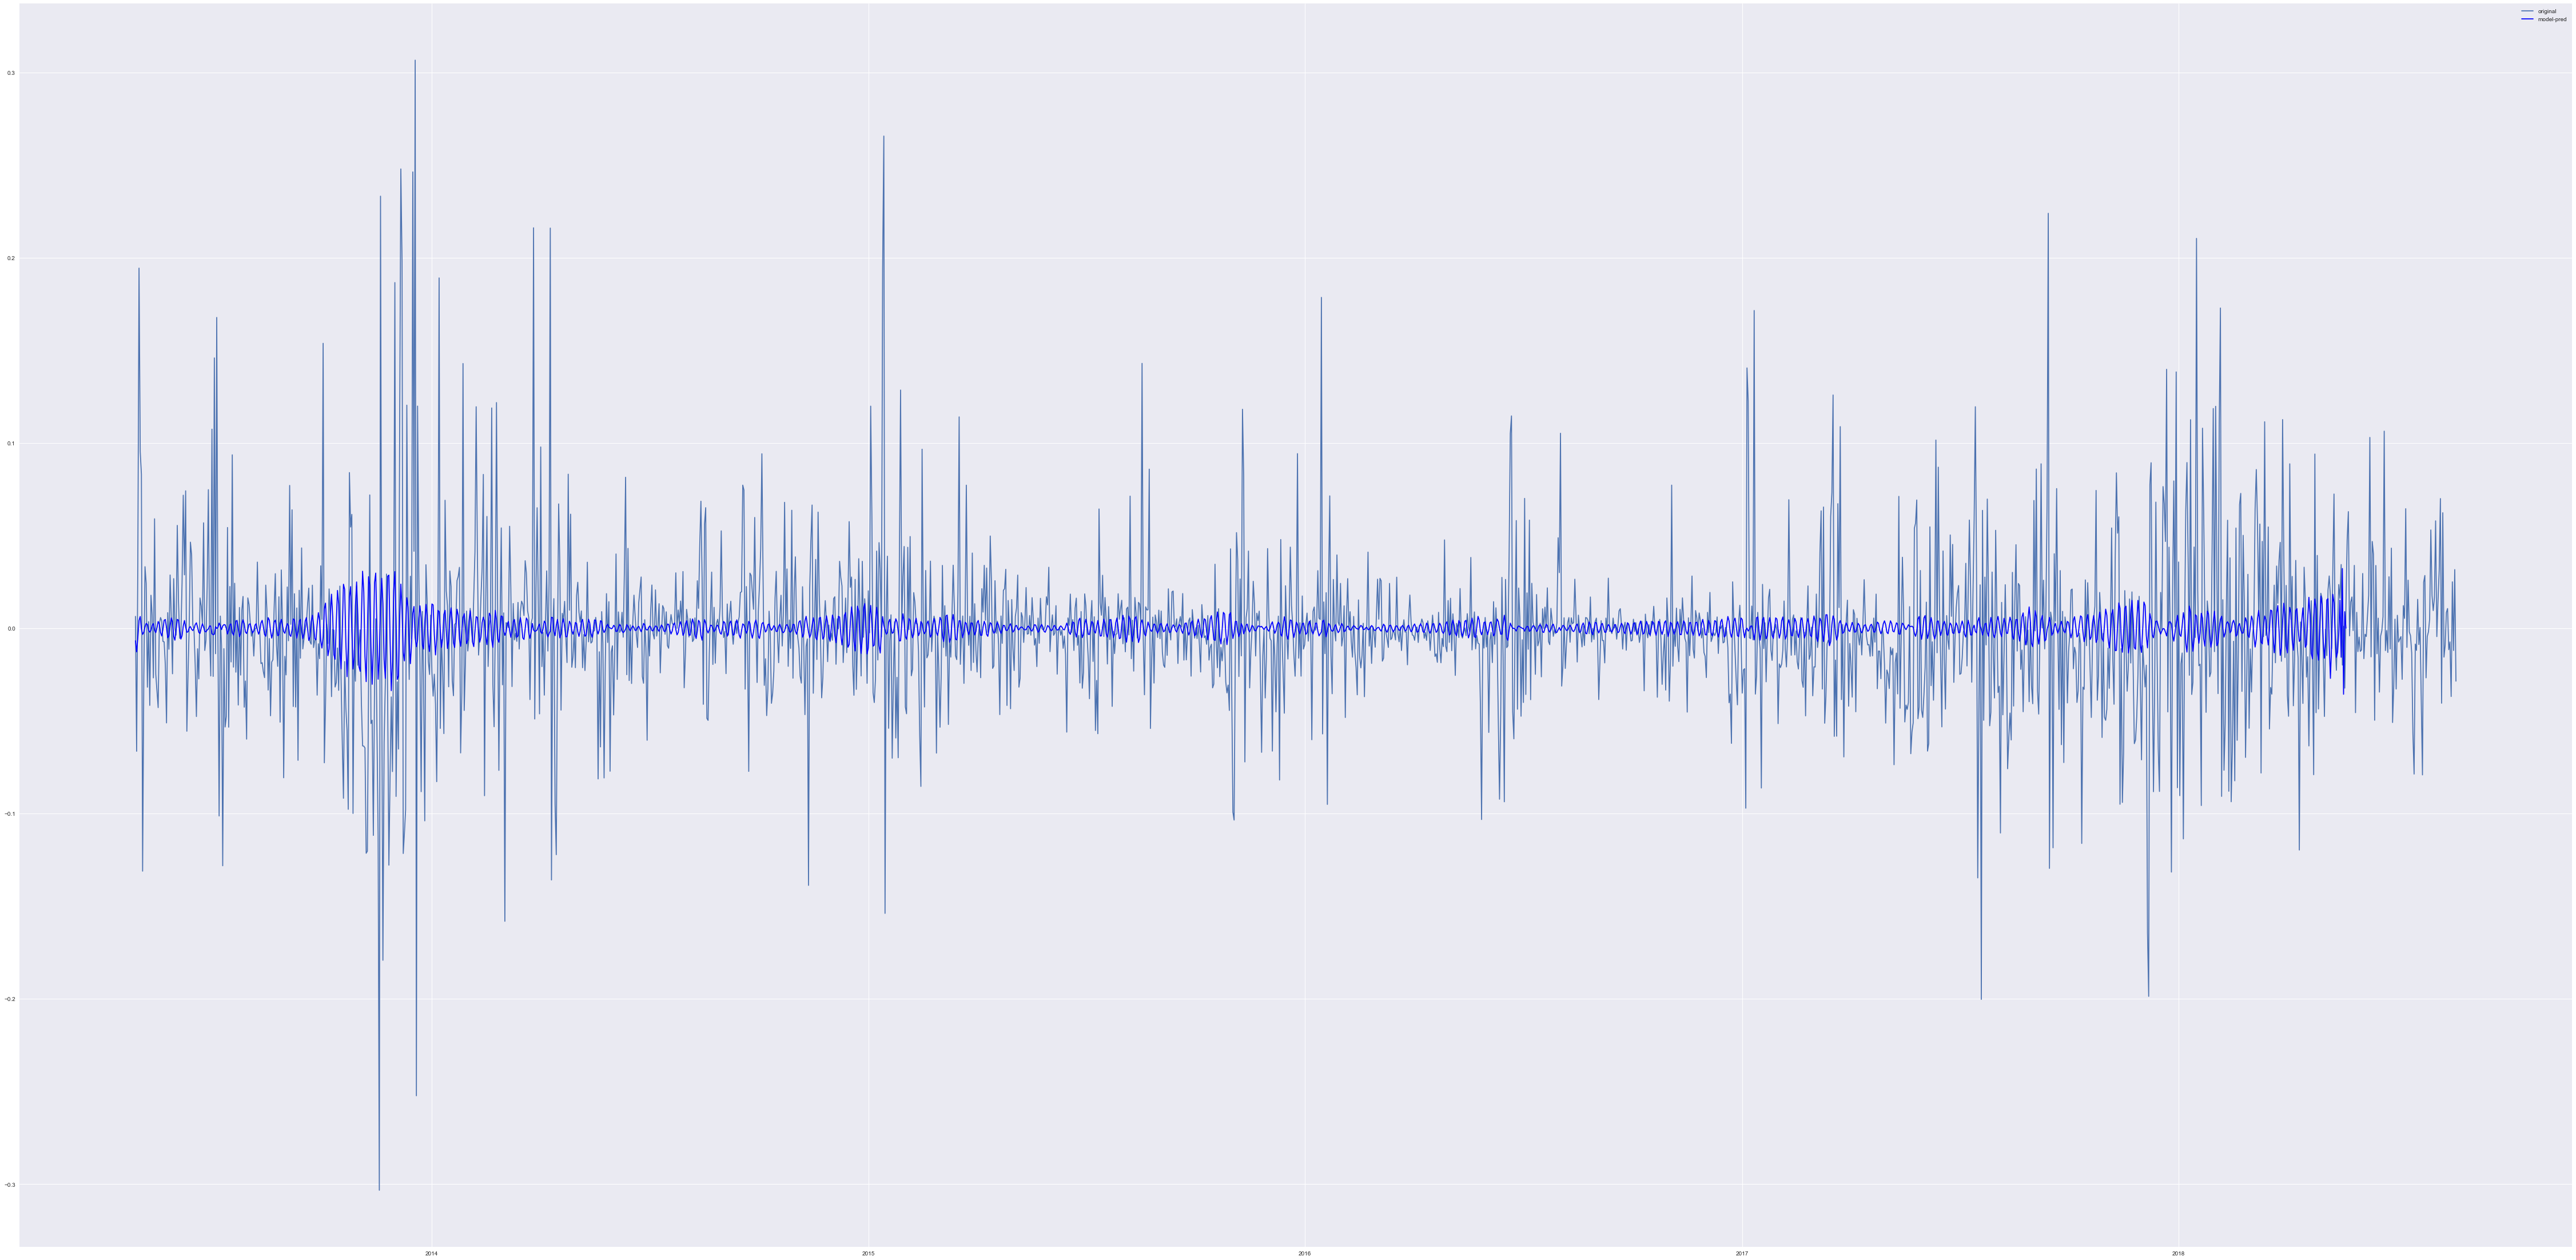

In [194]:
plt.figure(figsize=(80, 40))

plt.plot(df_bitcoin['日付開始'],df_bitcoin['pct_1d'],label="original")
plt.plot(sarimax_train_pred, c="b", label="model-pred")
plt.legend(loc='best')

# ARMA方式

In [75]:
# 結果表示のための関数
def ts_prediction(d, t, order, prepro='diff'):
    '''
    推測値を計算しMSEとコレログラムを描画する関数
    引数
    d: 元データが入ったデータフレーム
    t: 前処理を施したデータのarray / これを元に推測値を計算
    order : モデルの次数が入ったtuple ex) ARMA(3, 2) → (3, 2)
    ただし、今回はARのみに対応
    '''
    pred_seq = np.arange(50, len(d))
    preds = np.empty_like(pred_seq, dtype=float)

    for i, j in enumerate(pred_seq):
            preds[i] = AR(t[(j - 50):j]).fit(maxlag=order).predict(start=50, end=50)
         
    # 前処理の種類に対応した逆変換をおこなう
    if prepro == 'diff':
        pred_restored = preds + d[49:-1]
    elif prepro == 'pct':
        pred_restored = preds * d[49:-1] + d[49:-1]
    elif prepro == 'logdiff':
        pred_restored = np.exp(preds) * d[49:-1]
    else:
        print('{}は対応していない前処理です.'.format(prepro))
        return None

    # 残差の計算
    resid = d[50:].values - pred_restored.values
    # mseの計算
    mse = np.sum(resid**2) / len(pred_restored)

    print('MSE:', mse)
    print('約{}平均的に予測が外れている.'.format(round(np.sqrt(mse))))

    print('残差のコレログラム')
    sm.graphics.tsa.plot_pacf(resid, lags=10)
    plt.show()
    return None

In [81]:
# データの前処理
data1_diff = df_bitcoin['価格'].diff()
data1_rate = df_bitcoin['価格'].pct_change()
data1_logdiff = np.log(df_bitcoin['価格'] / df_bitcoin['価格'].shift(1))

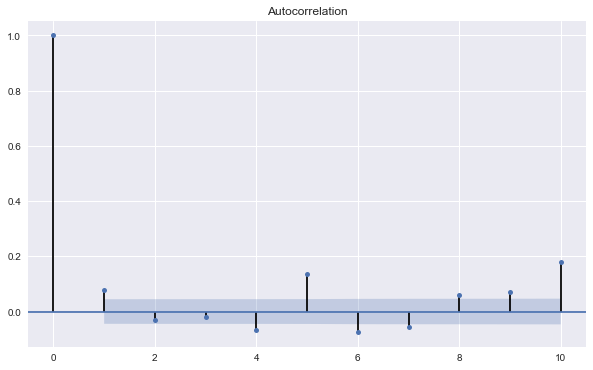

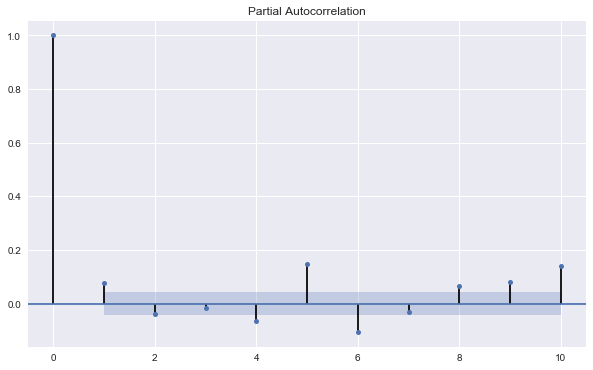

C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


MA(8)        26688.426047
MA(6)        26700.251594
ARMA(1,1)    26736.910469
ARMA(2,2)    26740.556489
AR(4)        26746.682053
ARMA(1,2)    26751.433594
AR(1)        26752.548541
ARMA(2,1)    26752.895602
dtype: float64

MSE: 62566.53617226937
約250.0平均的に予測が外れている.
残差のコレログラム


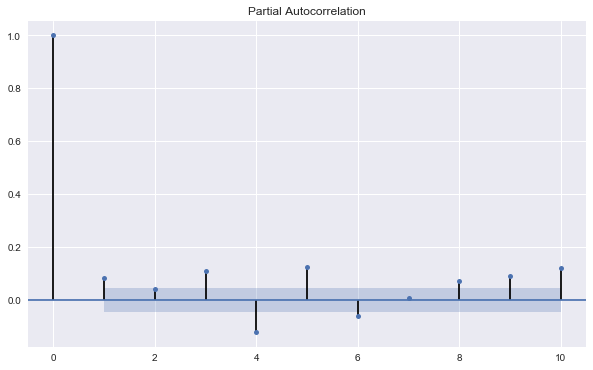

In [82]:
# data1
data = df_bitcoin['価格']
target = data1_diff.dropna().values  # targetのindexは元のdataより１前にずれる.

# コレログラムを描画し次数にあたりをつける。
sm.graphics.tsa.plot_acf(target, lags=10)
sm.graphics.tsa.plot_pacf(target, lags=10)
plt.show()


# それぞれのモデルのAICを計算
aic = pd.Series(index=['MA(6)', "MA(8)", "AR(1)", "AR(4)",
                       "ARMA(1,1)", "ARMA(1,2)", "ARMA(2,1)", "ARMA(2,2)"])
aic['MA(6)'] = ARMA(target, order=(0, 6)).fit().aic
aic['MA(8)'] = ARMA(target, order=(0, 8)).fit().aic
aic['AR(1)'] = ARMA(target, order=(1, 0)).fit().aic
aic['AR(4)'] = ARMA(target, order=(4, 0)).fit().aic
aic['ARMA(1,1)'] = ARMA(target, order=(1, 1)).fit().aic
aic['ARMA(1,2)'] = ARMA(target, order=(1, 2)).fit(trend='nc').aic
aic['ARMA(2,1)'] = ARMA(target, order=(2, 1)).fit().aic
aic['ARMA(2,2)'] = ARMA(target, order=(2, 2)).fit().aic

display(aic.sort_values())  # AICが最小のモデルは？

ts_prediction(data, target, order=4)

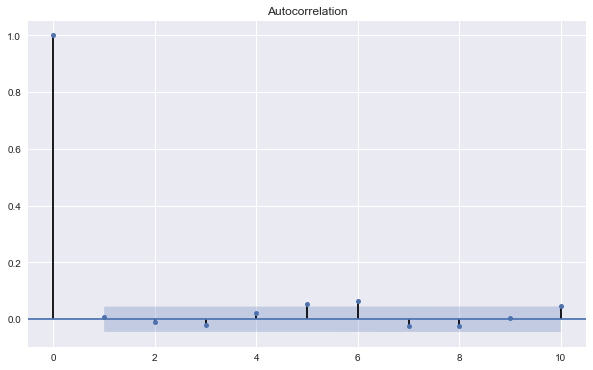

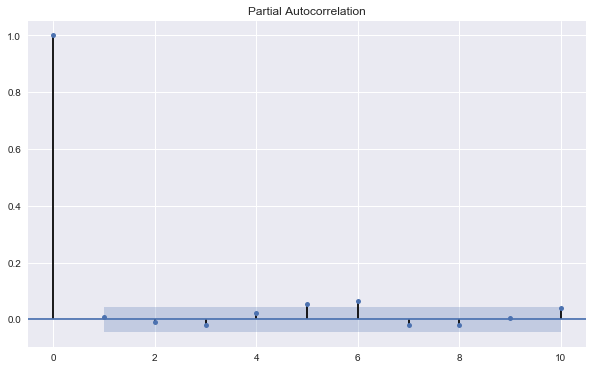

C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


ARMA(0,0)   -6556.656488
AR(1)       -6554.757700
MA(5)       -6553.619127
AR(4)       -6550.984547
ARMA(1,1)            NaN
ARMA(1,2)            NaN
ARMA(2,1)            NaN
ARMA(2,2)            NaN
dtype: float64

MSE: 64670.923930355595
約254.0平均的に予測が外れている.
残差のコレログラム


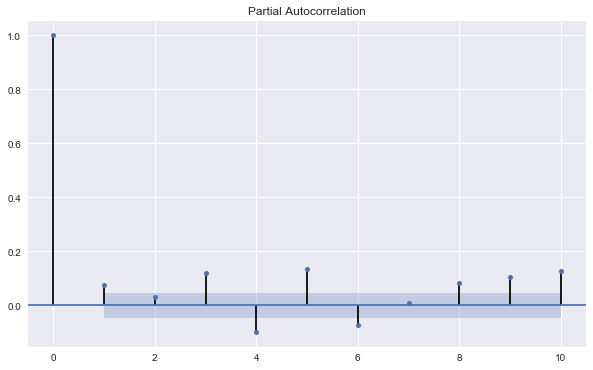

In [90]:
# data1
data = df_bitcoin['価格']
target = data1_rate.dropna().values  # targetのindexは元のdataより１前にずれる.

# コレログラムを描画し次数にあたりをつける。
sm.graphics.tsa.plot_acf(target, lags=10)
sm.graphics.tsa.plot_pacf(target, lags=10)
plt.show()

    # それぞれのモデルのAICを計算
aic = pd.Series(index=['MA(5)', "AR(1)", "AR(4)",
                       "ARMA(1,1)", "ARMA(1,2)", "ARMA(2,1)", "ARMA(2,2)"])
aic['MA(5)'] = ARMA(target, order=(0, 5)).fit().aic
aic['AR(1)'] = ARMA(target, order=(1, 0)).fit().aic
aic['AR(4)'] = ARMA(target, order=(4, 0)).fit().aic
aic['ARMA(0,0)'] = ARMA(target, order=(0, 0)).fit().aic


display(aic.sort_values())  # AICが最小のモデルは？

ts_prediction(data, target, prepro='pct', order=4)

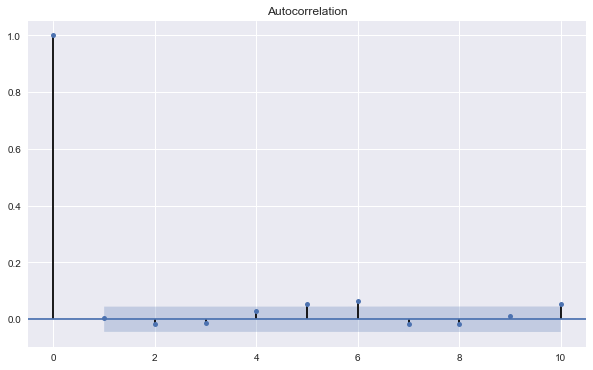

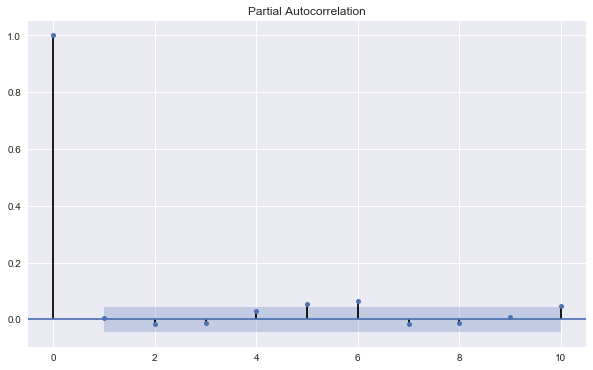

C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\hiroyuki_ohkawa\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


ARMA(0,0)   -6582.032733
AR(1)       -6580.066281
MA(5)       -6579.720904
AR(4)       -6576.474218
ARMA(1,1)            NaN
ARMA(1,2)            NaN
ARMA(2,1)            NaN
ARMA(2,2)            NaN
dtype: float64

MSE: 64483.28257686195
約254.0平均的に予測が外れている.
残差のコレログラム


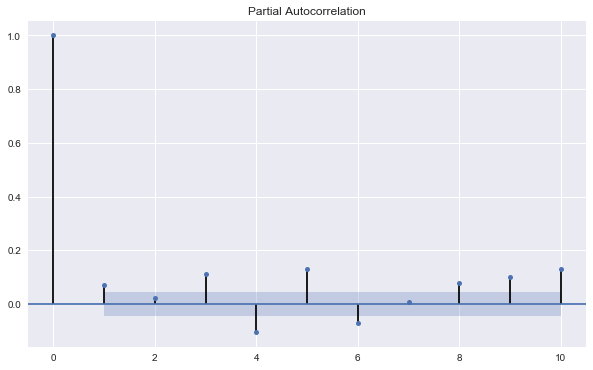

In [94]:
# data1
data = df_bitcoin['価格']
target = data1_logdiff.dropna().values  # targetのindexは元のdataより１前にずれる.

# コレログラムを描画し次数にあたりをつける。
sm.graphics.tsa.plot_acf(target, lags=10)
sm.graphics.tsa.plot_pacf(target, lags=10)
plt.show()

# それぞれのモデルのAICを計算
aic = pd.Series(index=['MA(5)', "AR(1)", "AR(4)",
                       "ARMA(1,1)", "ARMA(1,2)", "ARMA(2,1)", "ARMA(2,2)"])
aic['MA(5)'] = ARMA(target, order=(0, 5)).fit().aic
aic['AR(1)'] = ARMA(target, order=(1, 0)).fit().aic
aic['AR(4)'] = ARMA(target, order=(4, 0)).fit().aic
aic['ARMA(0,0)'] = ARMA(target, order=(0, 0)).fit().aic

display(aic.sort_values())  # AICが最小のモデルは？

ts_prediction(data, target, prepro='logdiff', order=4)

In [ ]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

In [130]:
# 関数化
def AR_pred(index):
   
    # AR(1)を用いて予測
    pred = AR(target[index - 51:index - 1]).fit(maxlag=1).predict(start=50, end=50)#ここで定常化から予測までやってる

    # 実測値（Actual)と比べて予測値(Predict)はどうなっているでしょうか？
    plt.figure(figsize=(5, 5))
    plt.plot(np.arange(1, index), target[:index - 1])
    plt.scatter(np.arange(1, index), target[:index - 1], s=15)
    plt.scatter(index, target[index - 1], c='green', label='Actual', alpha=0.8, s=60)
    plt.scatter(index, pred, c='r', label='Predict', alpha=0.8)
    plt.legend()
    plt.show()

    # 逆変換し、原系列で見てみましょう.
    pred_restored = pred + df_bitcoin.loc[index - 1, '価格']
    plt.figure(figsize=(3, 3))
    plt.scatter(index, pred_restored, c='r', label='Predict')
    plt.plot(np.arange(index), df_bitcoin.loc[:index - 1,'価格'], c='green', linewidth=1, label='Predict')
    plt.scatter(index, df_bitcoin.loc[index, '価格'], s=28, color='green', label='Actual')
    plt.legend()
    ax.xaxis.set_major_formatter(FormatStrFormatter(df_bitcoin['価格']))
    plt.ylabel('austres', fontsize=17)
    plt.show()
    return None

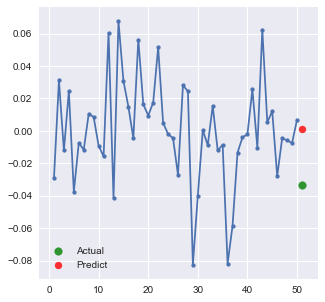

ValueError: x and y must have same first dimension, but have shapes (51,) and (50,)

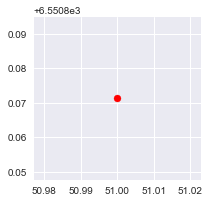

In [131]:

AR_pred(51)

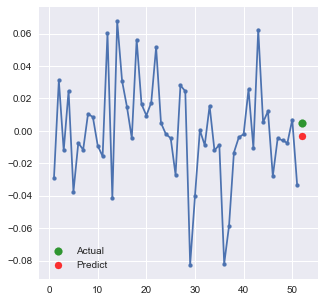

ValueError: x and y must have same first dimension, but have shapes (52,) and (51,)

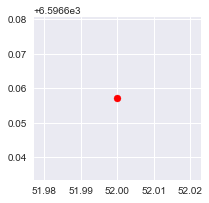

In [120]:
# 2回目の予測
AR_pred(52)

OverflowError: int too big to convert

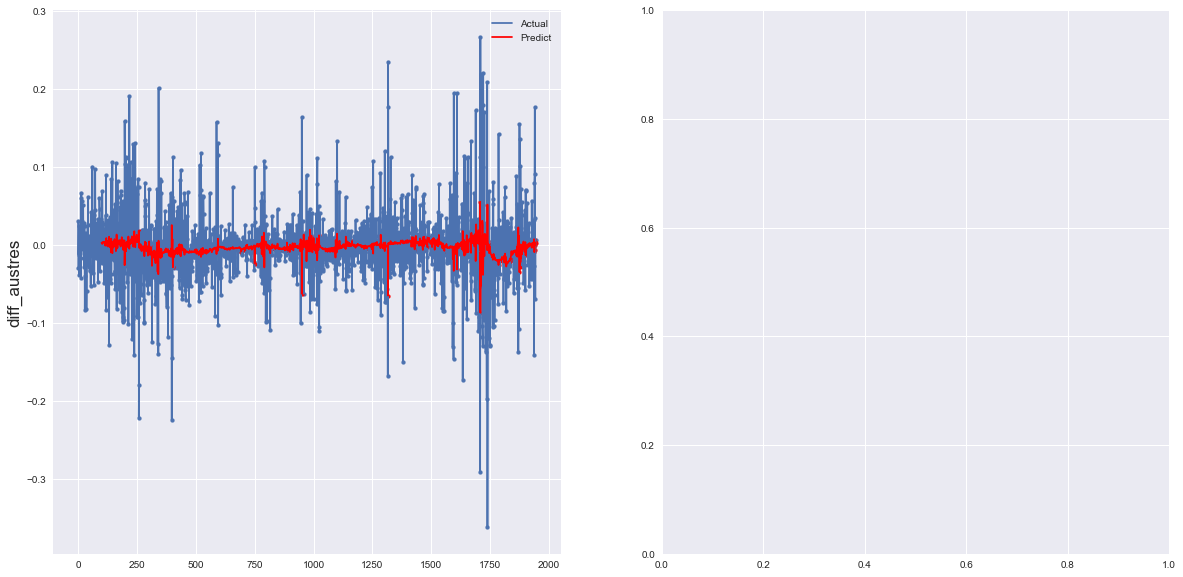

In [157]:

# SAVE1

# 次のfor文で利用する. pred_seq予測する値のインデックスを格納する. preds予測した値を格納する.
pred_seq = np.arange(100, len(df_bitcoin))
preds = np.empty_like(pred_seq, dtype=float)

for i, j in enumerate(pred_seq):
    preds[i] = AR(target[(j - 100):j]).fit(maxlag=1).predict(start=100, end=100)#ここの１文が重要

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].plot(np.arange(1, len(df_bitcoin)), target, label='Actual')
axes[0].plot(pred_seq, preds, c='r', label='Predict')
axes[0].scatter(np.arange(1, len(df_bitcoin)), target, label='', s=15)
axes[0].scatter(pred_seq, preds, c='r', label='', s=15)
axes[0].set_ylabel('diff_austres', fontsize=17)
axes[0].legend()

# 逆変換
pred_restored = preds + pd.TimedeltaIndex(df_bitcoin[100:-1]['日付開始'], unit='D')


axes[1].plot(np.arange(len(df_bitcoin)), df_bitcoin['価格'], c='green', linewidth=1, label='Actual')
axes[1].scatter(np.arange(len(data1)), df_bitcoin['価格'], c='green', s=15, label='')
axes[1].plot(pred_seq, pred_restored, c='r', linewidth=2, label='Predict')
axes[1].legend()
axes[1].set_ylabel('価格', fontsize=17)
axes[1].set_xlim(30, 89)
axes[1].set_ylim(15000, 18000)

plt.show()

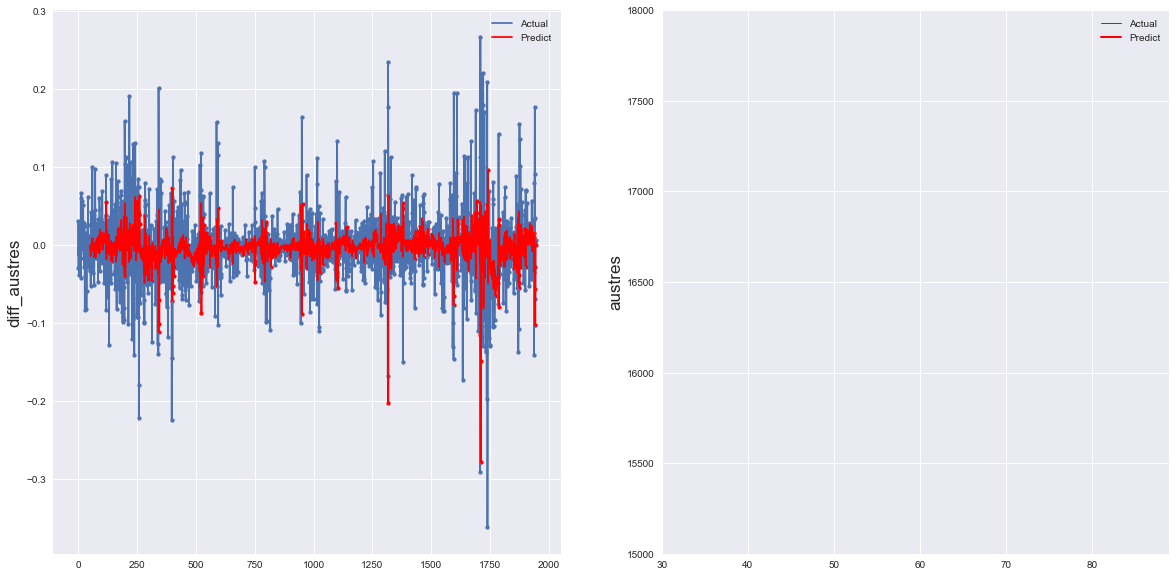

In [159]:
# SAVE1

# 次のfor文で利用する. pred_seq予測する値のインデックスを格納する. preds予測した値を格納する.
pred_seq = np.arange(50, len(df_bitcoin))
preds = np.empty_like(pred_seq, dtype=float)

for i, j in enumerate(pred_seq):
    preds[i] = AR(target[(j - 50):j]).fit(maxlag=4).predict(start=50, end=50)#ここの１文が重要

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].plot(np.arange(1, len(df_bitcoin)), target, label='Actual')
axes[0].plot(pred_seq, preds, c='r', label='Predict')
axes[0].scatter(np.arange(1, len(df_bitcoin)), target, label='', s=15)
axes[0].scatter(pred_seq, preds, c='r', label='', s=15)
axes[0].set_ylabel('diff_austres', fontsize=17)
axes[0].legend()

# 逆変換
pred_restored = preds + df_bitcoin[49:-1]['価格']

axes[1].plot(np.arange(len(df_bitcoin)), df_bitcoin['価格'], c='green', linewidth=1, label='Actual')
axes[1].scatter(np.arange(len(df_bitcoin)), df_bitcoin['価格'], c='green', s=15, label='')
axes[1].plot(pred_seq, pred_restored, c='r', linewidth=2, label='Predict')
axes[1].legend()
axes[1].set_ylabel('austres', fontsize=17)
axes[1].set_xlim(30, 89)
axes[1].set_ylim(15000, 18000)

plt.show()

ValueError: operands could not be broadcast together with shapes (1882,) (1883,) 

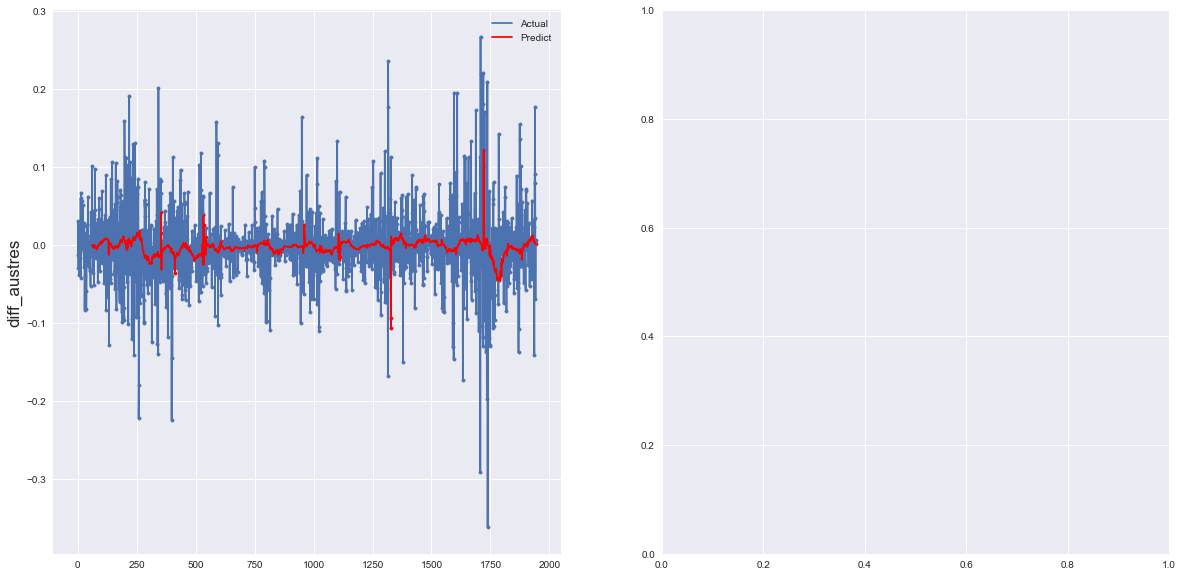

In [160]:
# 最後まで予測してみる

pred_seq = np.arange(61, len(df_bitcoin))
preds = np.empty_like(pred_seq, dtype=float)

for i, j in enumerate(pred_seq):
    preds[i] = AR(target[(j - 61):j - 11]).fit(maxlag=4).predict(start=50, end=59)[-1]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].plot(np.arange(1, len(df_bitcoin)), target, label='Actual')
axes[0].plot(pred_seq, preds, c='r', label='Predict')
axes[0].scatter(np.arange(1, len(df_bitcoin)), target, label='', s=12)
axes[0].scatter(pred_seq, preds, c='r', label='', s=12)
axes[0].legend()
axes[0].set_ylabel('diff_austres', fontsize=17)


# 逆変換
pred_restored = preds + df_bitcoin.loc[61:, '価格']


axes[1].plot(np.arange(len(data1)), df_bitcoin['価格'],
             c='green',  linewidth=1, label='Actual')
axes[1].plot(pred_seq, pred_restored, c='r', linewidth=1, label='Predict')
axes[1].scatter(np.arange(len(data1)), df_bitcoin['価格'], c='green', s=15, label='')
axes[1].scatter(pred_seq, pred_restored, c='r',  s=15, label='')
axes[1].legend()

axes[1].set_ylabel('価格', fontsize=17)
axes[1].set_xlim(50, 89)
axes[1].set_ylim(15750, 18000)


plt.show()

ValueError: x and y must have same first dimension, but have shapes (1882,) and (1893,)

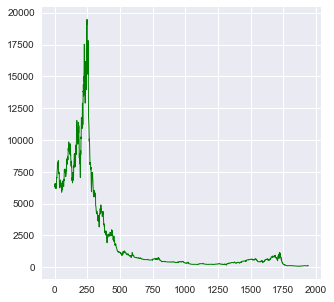

In [161]:
# MSEの計算  SAVE1を実行してからこのセルを実行してください

# 予測値と実測値の間に誤差があることを確認するためのグラフ
plt.figure(figsize=(5, 5))
plt.plot(np.arange(len(df_bitcoin)),df_bitcoin['価格'], c='green', linewidth=1, label='Actual')
plt.plot(pred_seq, pred_restored, c='r', linewidth=1, label='Predict')
plt.scatter(np.arange(len(df_bitcoin)), df_bitcoin['価格'], c='green', s=35)
plt.scatter(pred_seq, pred_restored, c='r', s=35)
plt.ylabel('価格', fontsize=17)
plt.xlim(57, 60)
plt.ylim(15900, 16000)
plt.show()


# mseの計算
# mseは実測値と予測値の間にどれだけ誤差があるかの指標.
resid = df_bitcoin.loc[50:, 'austres'] - pred_restored.values  #SAVE1を実行しなおすこと！！！！！
mse = np.sum(resid**2) / len(pred_restored)

print('MSE:', mse)
print('約{}平均的に予測が外れている.'.format(round(np.sqrt(mse))))

元データの自己相関


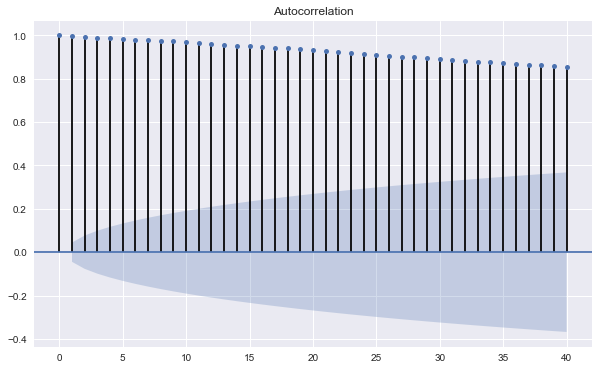

In [162]:
# 元データの自己相関
print('元データの自己相関')
sm.graphics.tsa.plot_acf(df_bitcoin['価格'], lags=40)
plt.show()

In [163]:
# 残差の自己相関
print('残差の自己相関')
sm.graphics.tsa.plot_pacf(resid, lags=10)
plt.show()

残差の自己相関


NameError: name 'resid' is not defined

In [255]:
np.asarray(df_bitcoin)

array([[Timestamp('2018-08-22 00:00:00'), 6486.25, 6816.79, ..., nan,
        nan, nan],
       [Timestamp('2018-08-21 00:00:00'), 6301.07, 6500.87, ..., nan,
        nan, nan],
       [Timestamp('2018-08-20 00:00:00'), 6500.51, 6536.92, ..., nan,
        nan, nan],
       ...,
       [Timestamp('2013-04-30 00:00:00'), 144.0, 146.93, ...,
        118.94428571430475, 120.40033333332357, 115.81833333333284],
       [Timestamp('2013-04-29 00:00:00'), 134.44, 147.49, ...,
        121.5814285714476, 120.58166666665691, 116.36333333333283],
       [Timestamp('2013-04-28 00:00:00'), 135.3, 135.98, ...,
        124.78142857144759, 120.76599999999026, 116.88499999999951]],
      dtype=object)

In [100]:
df_bitcoin.corr()

,価格,最高価格,最低価格,終値,時価総額,kouteisa,difference_1day,difference_3day,difference_7day,difference_30day,...,pct_1d,pct_3d,pct_7d,pct_30d,pct_60d,rolling_mean_1d,rolling_mean_3d,rolling_mean_7d,rolling_mean_30d,rolling_mean_60d
価格,1.000000,0.998909,0.998055,0.997537,0.999836,0.818965,0.029986,0.054947,0.083209,0.179421,...,0.030549,0.056392,0.090074,0.198560,0.248723,1.000000,0.998557,0.995154,0.971933,0.940502
最高価格,0.998909,1.000000,0.998039,0.999149,0.998594,0.829722,-0.008491,0.033444,0.066342,0.171646,...,0.011031,0.044495,0.080503,0.193281,0.247864,0.998909,0.999329,0.996563,0.973928,0.941773
最低価格,0.998055,0.998039,1.000000,0.998720,0.998107,0.793159,-0.014589,0.029465,0.070145,0.169131,...,0.005794,0.042162,0.081837,0.192849,0.240502,0.998055,0.998734,0.995723,0.973660,0.943614
終値,0.997537,0.999149,0.998720,1.000000,0.997355,0.815371,-0.040152,0.014220,0.056784,0.165840,...,-0.007797,0.033254,0.074397,0.190003,0.243315,0.997537,0.999491,0.997042,0.974780,0.943334
時価総額,0.999836,0.998594,0.998107,0.997355,1.000000,0.815440,0.030242,0.055321,0.083815,0.179448,...,0.030025,0.055501,0.088798,0.195023,0.243446,0.999836,0.998377,0.994942,0.971741,0.940280
kouteisa,0.818965,0.829722,0.793159,0.815371,0.815440,1.000000,0.047475,0.062622,0.020152,0.162412,...,0.055653,0.056940,0.053622,0.161814,0.268181,0.818965,0.817139,0.817860,0.798837,0.761121
difference_1day,0.029986,-0.008491,-0.014589,-0.040152,0.030242,0.047475,1.000000,0.580240,0.374117,0.189603,...,0.547903,0.330019,0.222510,0.119870,0.074813,0.029986,-0.017936,-0.031712,-0.052361,-0.044273
difference_3day,0.054947,0.033444,0.029465,0.014220,0.055321,0.062622,0.580240,1.000000,0.650183,0.320359,...,0.318873,0.553326,0.369737,0.208463,0.119666,0.054947,0.012955,-0.034673,-0.081372,-0.071937
difference_7day,0.083209,0.066342,0.070145,0.056784,0.083815,0.020152,0.374117,0.650183,1.000000,0.506311,...,0.220920,0.375177,0.572583,0.321883,0.183481,0.083209,0.055746,0.001308,-0.111176,-0.105588
difference_30day,0.179421,0.171646,0.169131,0.165840,0.179448,0.162412,0.189603,0.320359,0.506311,1.000000,...,0.110683,0.196258,0.312740,0.609301,0.394608,0.179421,0.165969,0.138356,-0.027478,-0.134453


In [119]:
df_bitcoin#注意！単位はドル($)

,日付開始,価格,最高価格,最低価格,終値,ボリューム,時価総額,kouteisa,difference_1day,difference_3day,...,pct_1d,pct_3d,pct_7d,pct_30d,pct_60d,rolling_mean_1d,rolling_mean_3d,rolling_mean_7d,rolling_mean_30d,rolling_mean_60d
1,2018-08-22,6486.25,6816.79,6310.11,6376.71,4668110000,1.117148e+11,506.68,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,6486.25,NaN,NaN,NaN,NaN
2,2018-08-21,6301.07,6500.87,6298.24,6488.76,3377180000,1.085136e+11,202.63,-185.18,NaN,...,-0.028550,NaN,NaN,NaN,NaN,6301.07,NaN,NaN,NaN,NaN
3,2018-08-20,6500.51,6536.92,6297.93,6308.53,3665100000,1.119361e+11,238.99,199.44,NaN,...,0.031652,NaN,NaN,NaN,NaN,6500.51,6429.276667,NaN,NaN,NaN
4,2018-08-19,6422.57,6537.98,6361.55,6506.07,3311170000,1.105826e+11,176.43,-77.94,-63.68,...,-0.011990,-0.009818,NaN,NaN,NaN,6422.57,6408.050000,NaN,NaN,NaN
5,2018-08-18,6583.43,6617.35,6353.73,6423.76,3984520000,1.133389e+11,263.62,160.86,282.36,...,0.025046,0.044811,NaN,NaN,NaN,6583.43,6502.170000,NaN,NaN,NaN
6,2018-08-17,6340.91,6582.50,6324.97,6580.63,4992990000,1.091516e+11,257.53,-242.52,-159.60,...,-0.036838,-0.024552,NaN,NaN,NaN,6340.91,6448.970000,NaN,NaN,NaN
7,2018-08-16,6294.23,6473.50,6276.41,6334.73,4328420000,1.083358e+11,197.09,-46.68,-128.34,...,-0.007362,-0.019983,NaN,NaN,NaN,6294.23,6406.190000,6418.424286,NaN,NaN
8,2018-08-15,6221.42,6588.49,6221.42,6308.52,4895450000,1.070701e+11,367.07,-72.81,-362.01,...,-0.011568,-0.054988,-0.040829,NaN,NaN,6221.42,6285.520000,6380.591429,NaN,NaN
9,2018-08-14,6287.66,6287.94,5971.05,6199.71,5301700000,1.081991e+11,316.89,66.24,-53.25,...,0.010647,-0.008398,-0.002128,NaN,NaN,6287.66,6267.770000,6378.675714,NaN,NaN
10,2018-08-13,6341.36,6537.05,6225.72,6297.57,4083980000,1.091115e+11,311.33,53.70,47.13,...,0.008541,0.007488,-0.024483,NaN,NaN,6341.36,6283.480000,6355.940000,NaN,NaN


Text(0.5,1,'高値と安値の差と3か月後の差分の相関関係')

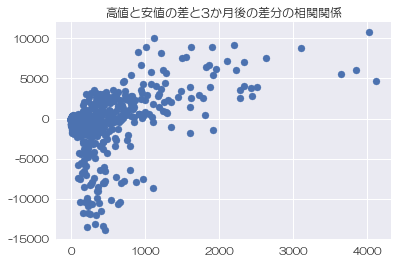

In [154]:
plt.scatter(df_bitcoin['kouteisa'],df_bitcoin['difference_60day'])
plt.title('高値と安値の差と3か月後の差分の相関関係')